# Learning GAN and WGAN for a synthetic 2-dimensional dataset

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2324/tp2_generative_networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebooks on Google Colab.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

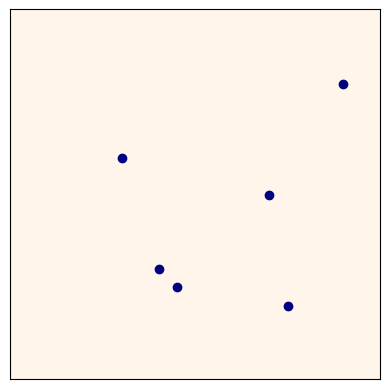

In [2]:
d = 2   # dimension of the data points
n = 6   # number of data points

y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2

y[1, 0] = 0.75
y[1, 1] = 0.8

y[2, 0] = 0.3
y[2, 1] = 0.4

y[3, 0] = 0.4
y[3, 1] = 0.7

y[4, 0] = 0.45
y[4, 1] = 0.75

y[5, 0] = 0.7
y[5, 1] = 0.5

nu = torch.ones(n, device=device)/n  # equal masses (nu is the empirical measure of the data)

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

In [3]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

torch.Size([100, 2])


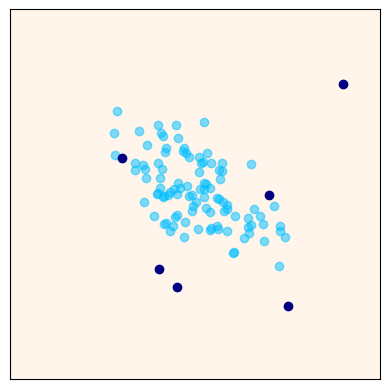

In [4]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

z = torch.randn(b, n_in, device=device)
x = G(z)

print(x.shape)

xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

# Exercise 1: Learn a GAN

### Define Discriminator Architecture

QUESTION: Examine the layers and parameters of the following discriminative network.

In [5]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = nn.Sigmoid()(self.fc3(y))
    return y

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.390805


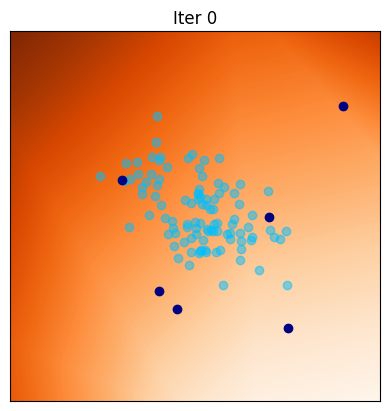

[100/1000], 1.291726


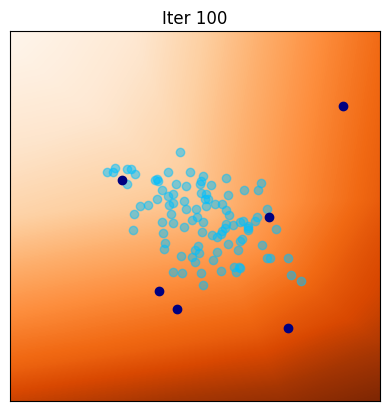

[200/1000], 0.957434


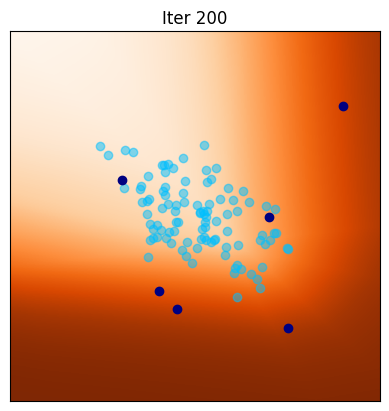

[300/1000], 0.788502


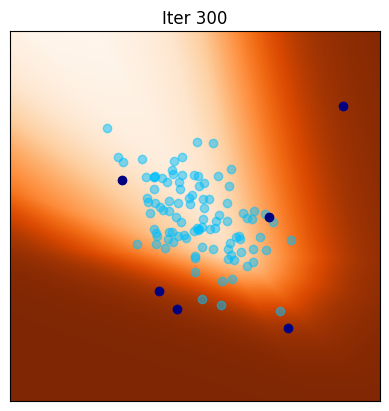

[400/1000], 0.606889


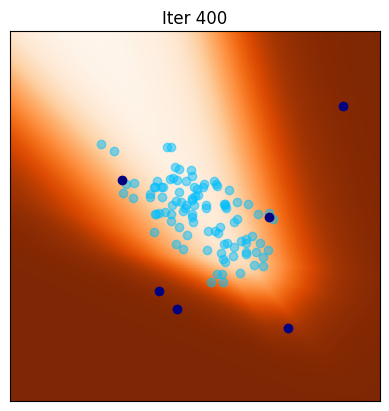

[500/1000], 0.517033


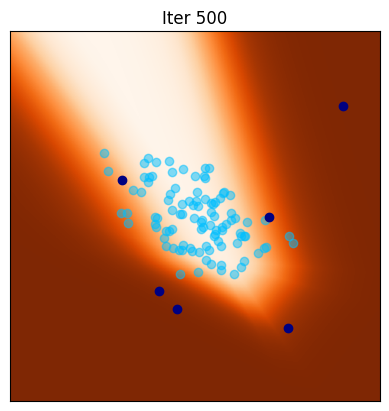

[600/1000], 0.406865


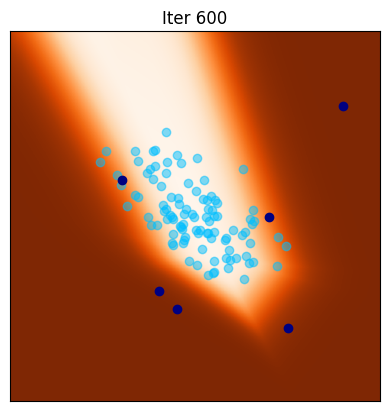

[700/1000], 0.407084


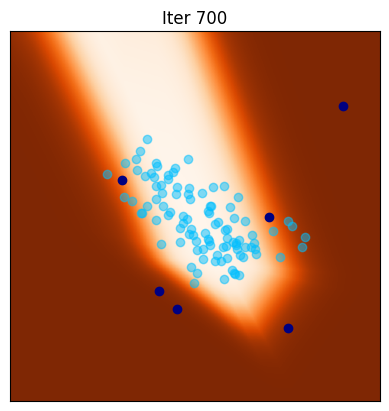

[800/1000], 0.304800


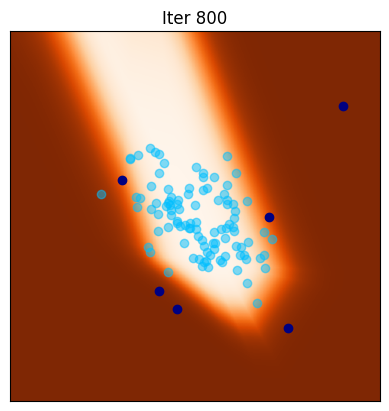

[900/1000], 0.330098


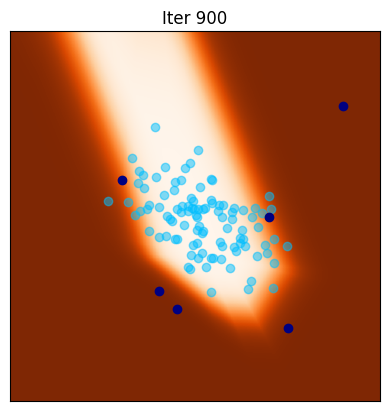

In [6]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    # Generate batch of fake points
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    # Compute the loss
    Dloss = -torch.mean(torch.log(1-D(x))) - torch.mean(torch.log(D(y)))
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


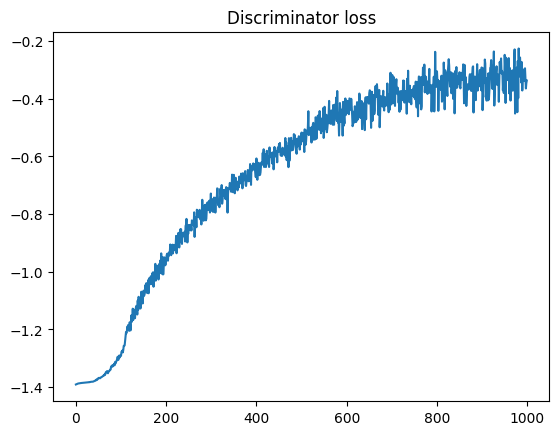

In [7]:
### Plot the evolution of the discriminator loss ###

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 1.2603	Loss_G: -0.7648


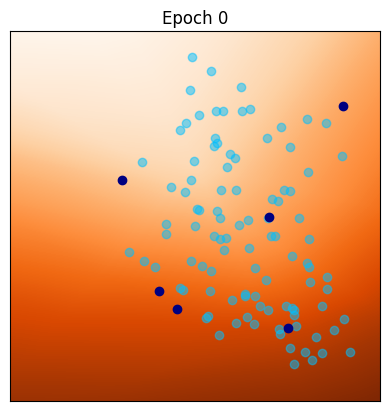

[1/100] 	Loss_D: 1.1998	Loss_G: -0.9730
[2/100] 	Loss_D: 1.3756	Loss_G: -0.6796
[3/100] 	Loss_D: 1.2350	Loss_G: -0.7584
[4/100] 	Loss_D: 1.1732	Loss_G: -0.7334
[5/100] 	Loss_D: 1.2566	Loss_G: -0.6872
[6/100] 	Loss_D: 1.2579	Loss_G: -0.6682
[7/100] 	Loss_D: 1.2648	Loss_G: -0.7299
[8/100] 	Loss_D: 1.2831	Loss_G: -0.7179
[9/100] 	Loss_D: 1.1120	Loss_G: -1.7751
[10/100] 	Loss_D: 0.8945	Loss_G: -0.6775


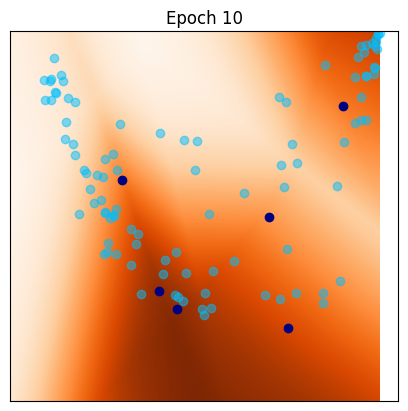

[11/100] 	Loss_D: 1.1724	Loss_G: -1.1239
[12/100] 	Loss_D: 1.1119	Loss_G: -0.7776
[13/100] 	Loss_D: 1.2269	Loss_G: -0.7784
[14/100] 	Loss_D: 1.2980	Loss_G: -0.6993
[15/100] 	Loss_D: 1.3018	Loss_G: -0.6967
[16/100] 	Loss_D: 1.2780	Loss_G: -0.6450
[17/100] 	Loss_D: 1.2828	Loss_G: -0.6317
[18/100] 	Loss_D: 1.2550	Loss_G: -0.7069
[19/100] 	Loss_D: 1.2325	Loss_G: -0.6700
[20/100] 	Loss_D: 1.2511	Loss_G: -0.6901


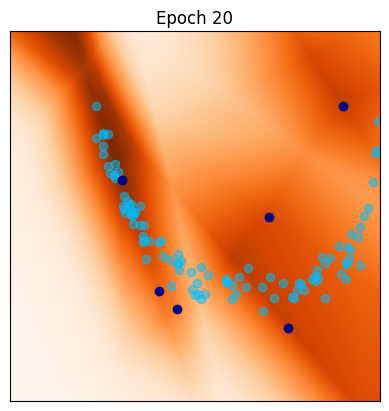

[21/100] 	Loss_D: 1.1259	Loss_G: -0.9877
[22/100] 	Loss_D: 1.0743	Loss_G: -1.2175
[23/100] 	Loss_D: 1.0692	Loss_G: -0.9776
[24/100] 	Loss_D: 1.1291	Loss_G: -0.6837
[25/100] 	Loss_D: 1.2232	Loss_G: -0.6489
[26/100] 	Loss_D: 1.2089	Loss_G: -0.6398
[27/100] 	Loss_D: 1.1585	Loss_G: -0.6649
[28/100] 	Loss_D: 1.1654	Loss_G: -0.6440
[29/100] 	Loss_D: 1.1601	Loss_G: -0.5577
[30/100] 	Loss_D: 1.1509	Loss_G: -0.5557


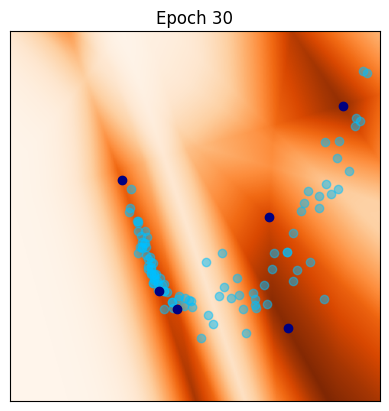

[31/100] 	Loss_D: 1.1403	Loss_G: -0.5919
[32/100] 	Loss_D: 1.1246	Loss_G: -0.6842
[33/100] 	Loss_D: 1.1222	Loss_G: -0.7041
[34/100] 	Loss_D: 1.0107	Loss_G: -0.6626
[35/100] 	Loss_D: 1.0989	Loss_G: -0.6066
[36/100] 	Loss_D: 1.0595	Loss_G: -0.6895
[37/100] 	Loss_D: 1.0802	Loss_G: -0.6995
[38/100] 	Loss_D: 1.0033	Loss_G: -0.8405
[39/100] 	Loss_D: 0.9763	Loss_G: -0.6895
[40/100] 	Loss_D: 1.0321	Loss_G: -0.5957


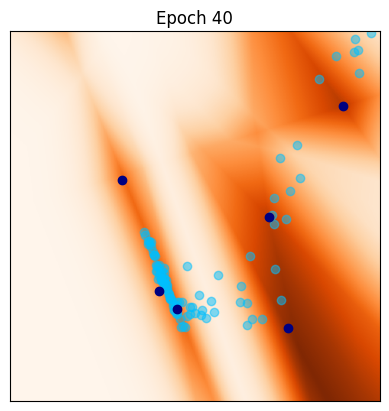

[41/100] 	Loss_D: 1.0284	Loss_G: -0.7268
[42/100] 	Loss_D: 1.0877	Loss_G: -0.5738
[43/100] 	Loss_D: 1.0367	Loss_G: -0.6364
[44/100] 	Loss_D: 1.0363	Loss_G: -0.6737
[45/100] 	Loss_D: 0.8918	Loss_G: -0.8917
[46/100] 	Loss_D: 0.9368	Loss_G: -0.7222
[47/100] 	Loss_D: 0.9638	Loss_G: -0.8027
[48/100] 	Loss_D: 0.9185	Loss_G: -0.8665
[49/100] 	Loss_D: 0.8755	Loss_G: -1.0001
[50/100] 	Loss_D: 0.8421	Loss_G: -0.8875


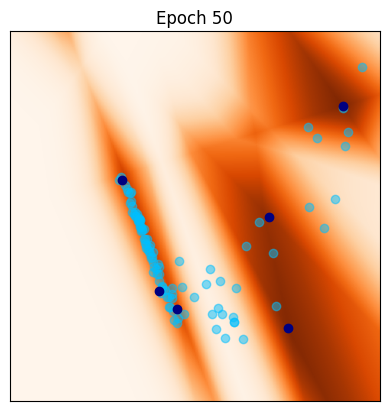

[51/100] 	Loss_D: 1.0995	Loss_G: -0.6885
[52/100] 	Loss_D: 0.9447	Loss_G: -0.8774
[53/100] 	Loss_D: 0.8924	Loss_G: -0.7637
[54/100] 	Loss_D: 0.8933	Loss_G: -0.8172
[55/100] 	Loss_D: 0.9956	Loss_G: -0.5800
[56/100] 	Loss_D: 1.1471	Loss_G: -0.5491
[57/100] 	Loss_D: 0.9452	Loss_G: -0.7396
[58/100] 	Loss_D: 0.9011	Loss_G: -0.7403
[59/100] 	Loss_D: 1.0189	Loss_G: -0.6578
[60/100] 	Loss_D: 0.9624	Loss_G: -0.6659


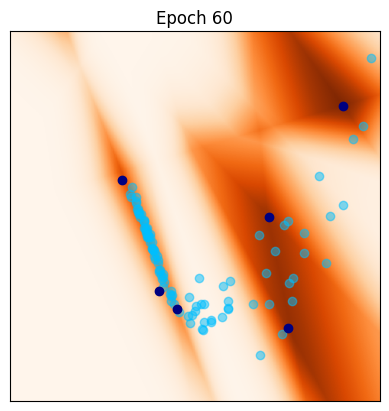

[61/100] 	Loss_D: 0.9728	Loss_G: -0.8150
[62/100] 	Loss_D: 1.0404	Loss_G: -0.5784
[63/100] 	Loss_D: 1.0915	Loss_G: -0.5007
[64/100] 	Loss_D: 0.9966	Loss_G: -0.6522
[65/100] 	Loss_D: 0.9539	Loss_G: -0.9540
[66/100] 	Loss_D: 1.0997	Loss_G: -0.6305
[67/100] 	Loss_D: 0.9141	Loss_G: -0.7400
[68/100] 	Loss_D: 1.1477	Loss_G: -0.5655
[69/100] 	Loss_D: 0.9613	Loss_G: -0.7238
[70/100] 	Loss_D: 0.7905	Loss_G: -0.8678


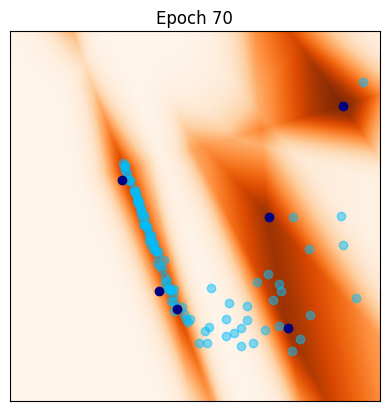

[71/100] 	Loss_D: 0.8541	Loss_G: -0.7994
[72/100] 	Loss_D: 0.8482	Loss_G: -0.8984
[73/100] 	Loss_D: 0.7702	Loss_G: -1.0058
[74/100] 	Loss_D: 0.9372	Loss_G: -0.7000
[75/100] 	Loss_D: 0.8482	Loss_G: -0.9339
[76/100] 	Loss_D: 0.7726	Loss_G: -0.9065
[77/100] 	Loss_D: 0.8394	Loss_G: -0.9921
[78/100] 	Loss_D: 0.8050	Loss_G: -0.8537
[79/100] 	Loss_D: 0.8551	Loss_G: -0.8670
[80/100] 	Loss_D: 0.8733	Loss_G: -0.7906


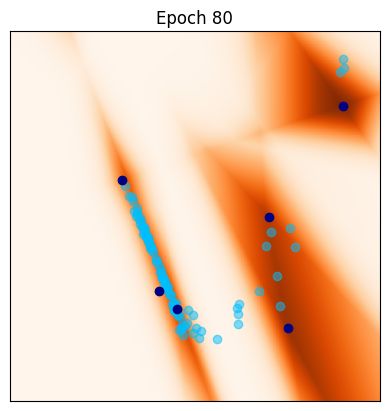

[81/100] 	Loss_D: 1.1010	Loss_G: -0.5929
[82/100] 	Loss_D: 0.8590	Loss_G: -0.8786
[83/100] 	Loss_D: 0.8054	Loss_G: -0.7889
[84/100] 	Loss_D: 0.9096	Loss_G: -0.7876
[85/100] 	Loss_D: 0.8659	Loss_G: -0.6010
[86/100] 	Loss_D: 0.8785	Loss_G: -0.7752
[87/100] 	Loss_D: 0.7765	Loss_G: -0.7966
[88/100] 	Loss_D: 1.0654	Loss_G: -0.3977
[89/100] 	Loss_D: 1.0015	Loss_G: -0.5059
[90/100] 	Loss_D: 0.8667	Loss_G: -0.7415


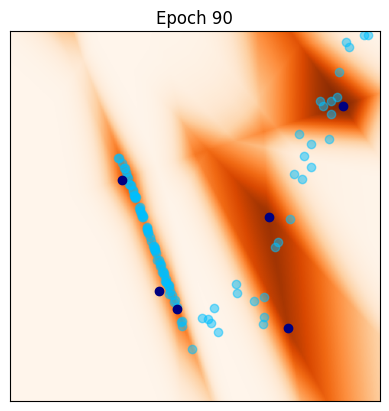

[91/100] 	Loss_D: 0.7768	Loss_G: -1.0905
[92/100] 	Loss_D: 0.7340	Loss_G: -0.8923
[93/100] 	Loss_D: 0.7959	Loss_G: -1.3969
[94/100] 	Loss_D: 0.7439	Loss_G: -0.8858
[95/100] 	Loss_D: 0.9103	Loss_G: -0.6747
[96/100] 	Loss_D: 0.8924	Loss_G: -0.7441
[97/100] 	Loss_D: 0.9924	Loss_G: -0.4759
[98/100] 	Loss_D: 0.9052	Loss_G: -0.5392
[99/100] 	Loss_D: 0.8327	Loss_G: -0.6689


<All keys matched successfully>

In [8]:
lrgen = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for discriminator
## parameters for training
n_epochs = 100
niterD=100
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=20, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# Optimizer for generator
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))
optimG = optim.Adam(G.parameters(), lr=lrgen, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    Gloss = torch.tensor(0.0, device=device)
    Dloss = torch.tensor(0.0, device=device)
    for iter in range(0,niterD):
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        optimD.zero_grad()
        Dloss = -torch.mean(torch.log(1-D(x))) - torch.mean(torch.log(D(y)))
        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        optimG.zero_grad()
        Gloss = torch.mean(torch.log(1-D(x)))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=20, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

We observe mode collapse.

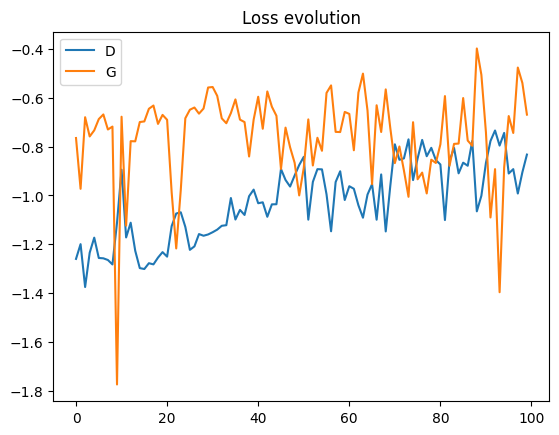

In [9]:
### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

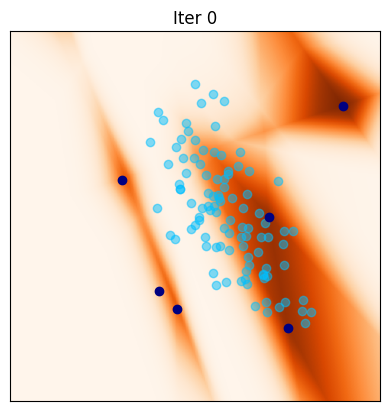

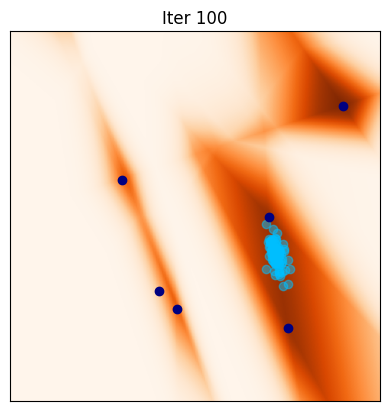

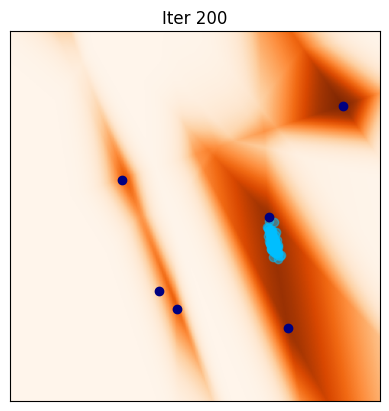

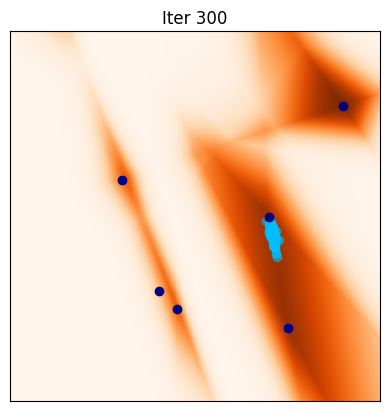

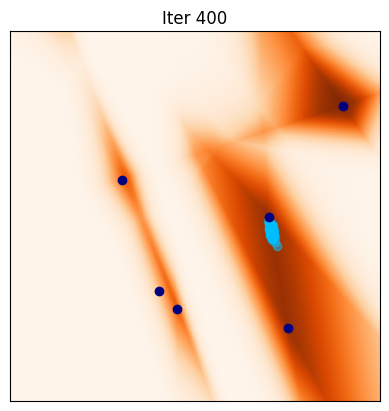

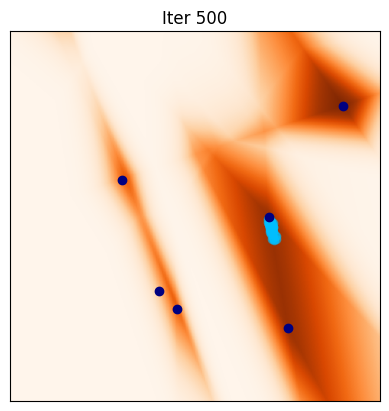

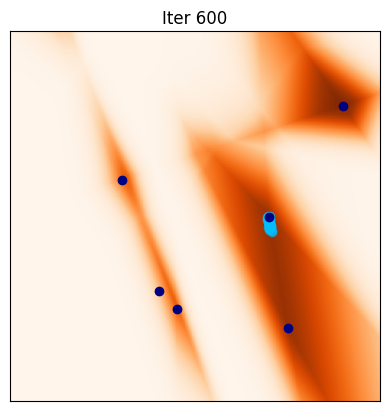

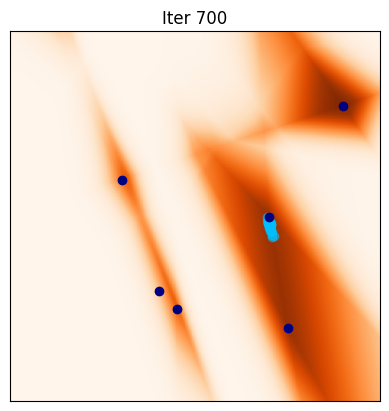

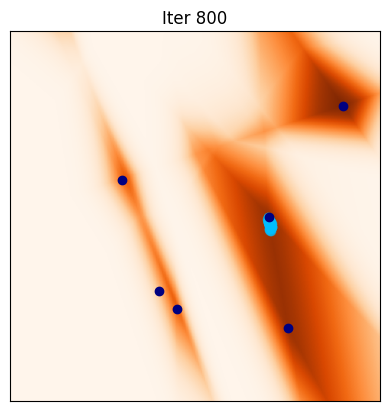

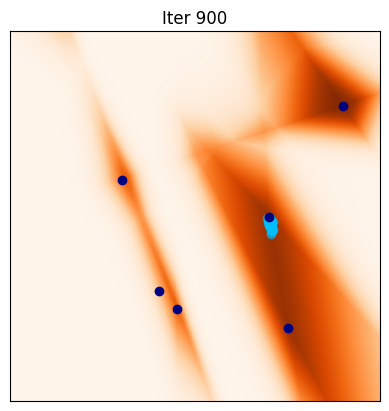

In [10]:
## For a fixed discriminator,train the generator only for a few iterations

lrgen = 0.002   # learning rate for generator
## parameters for training
n_iter_G = 1000
iter_display = 100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator only
G = Generator(n_in=n_in, n_out=d, n_hid=20, nlayers=3, device=device)

# Optimizer for generator
optimG = optim.Adam(G.parameters(), lr=lrgen, betas=(beta_1, beta_2))

Glosses = []

# Main loop
for iter in range(n_iter_G):

    ############################
    ### Train generator (niterG iterations)
    ############################
    Gloss = torch.tensor(0.0, device=device)
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    optimG.zero_grad()
    Gloss = torch.mean(torch.log(1-D(x)))
    Gloss.backward()
    optimG.step()

    # Output training stats
    Glosses.append(Gloss.item())

    if(iter % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

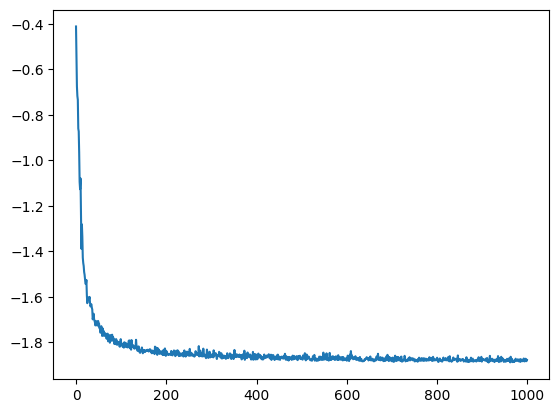

In [11]:
plt.plot(Glosses)

We observe mode collapse.

<br/><br/><br/><br/>

# Exercise 2: Learn a WGAN with 1-Lipschitz discriminator

In [12]:
# Discriminator adapted for WGAN-GP
#  Remark the absence of final sigmoid function in this case.

class DWGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DWGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

[0/1000], 0.025363


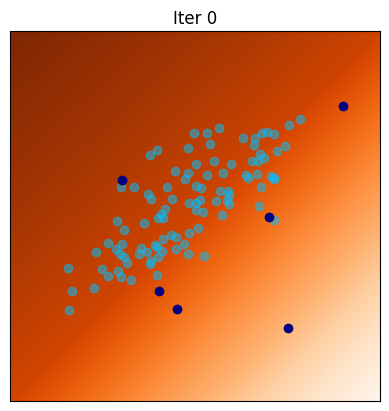

[100/1000], -0.000002


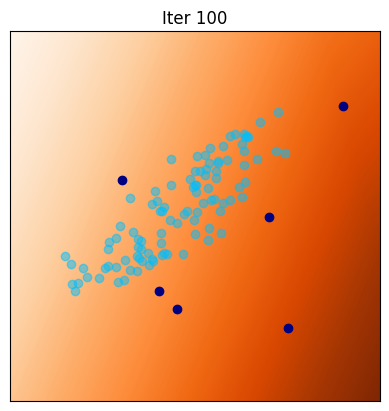

[200/1000], -0.000004


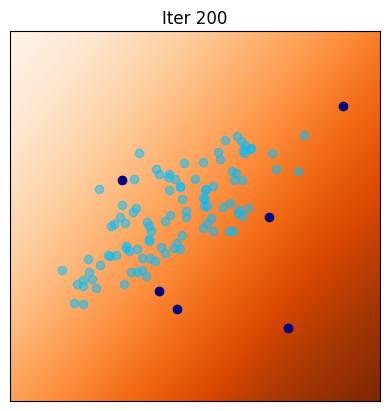

[300/1000], -0.000006


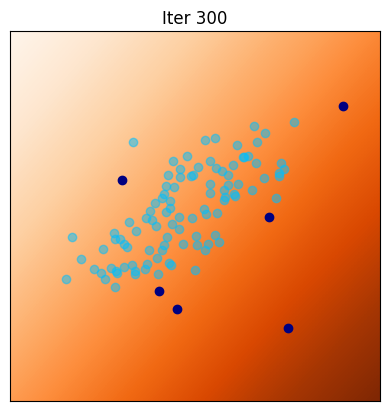

[400/1000], -0.000007


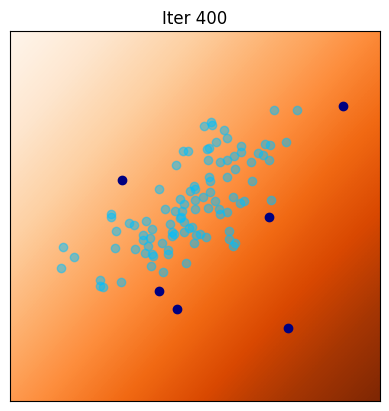

[500/1000], -0.000007


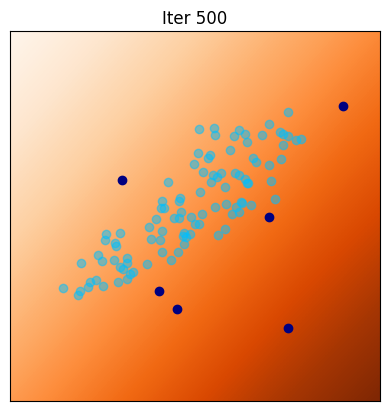

[600/1000], -0.000007


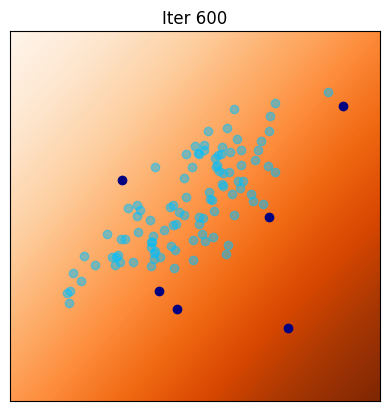

[700/1000], -0.000007


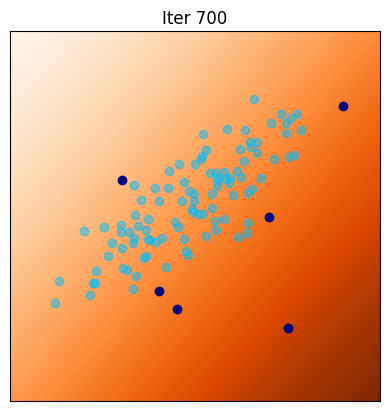

[800/1000], -0.000008


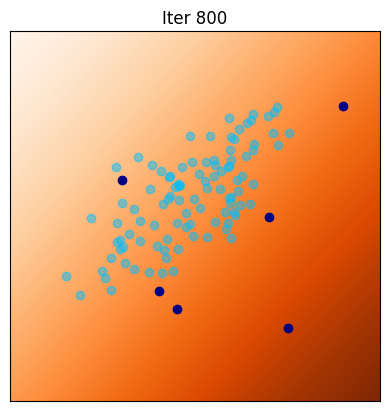

[900/1000], -0.000007


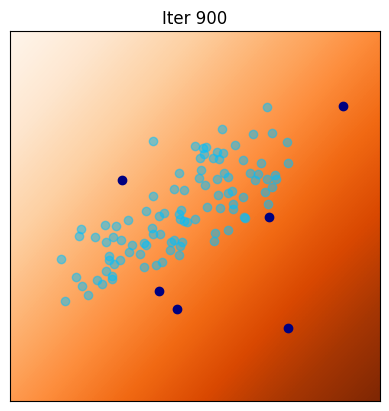

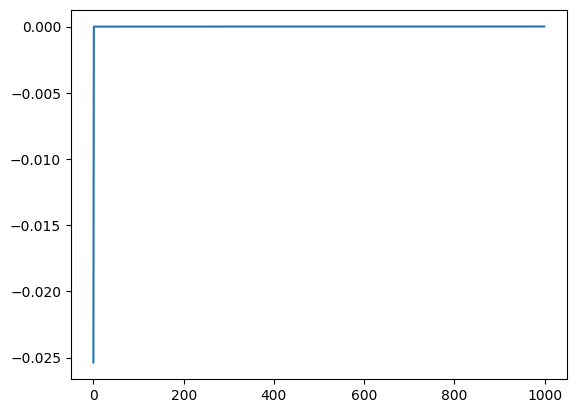

In [13]:
torch.manual_seed(3)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lrgen)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000

clip_value = 0.01

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    # Generate batch of fake points
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    # Compute the loss
    Dloss = torch.mean(D(x)) - torch.mean(D(y))
    Dloss.backward()
    optimD.step()
    # Clip weights of discriminator
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)
    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

QUESTION: Now, train both the generator and discriminator with the WGAN loss and weight clipping.

[0/100] 	Loss_D: -0.0067	Loss_G: 0.0679


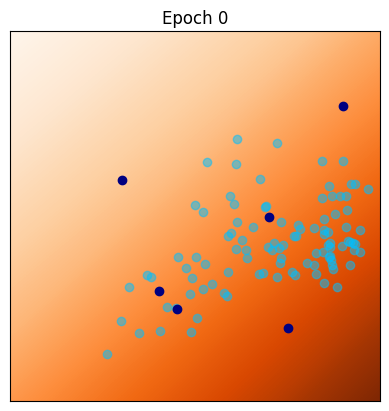

[1/100] 	Loss_D: -0.0050	Loss_G: 0.1358
[2/100] 	Loss_D: -0.0069	Loss_G: 0.1252
[3/100] 	Loss_D: -0.0018	Loss_G: 0.1010
[4/100] 	Loss_D: -0.0091	Loss_G: 0.1144
[5/100] 	Loss_D: -0.0000	Loss_G: 0.1007
[6/100] 	Loss_D: -0.0203	Loss_G: 0.0608
[7/100] 	Loss_D: -0.0107	Loss_G: 0.0737
[8/100] 	Loss_D: -0.0069	Loss_G: 0.0052
[9/100] 	Loss_D: -0.0161	Loss_G: 0.0931
[10/100] 	Loss_D: -0.0043	Loss_G: 0.0864


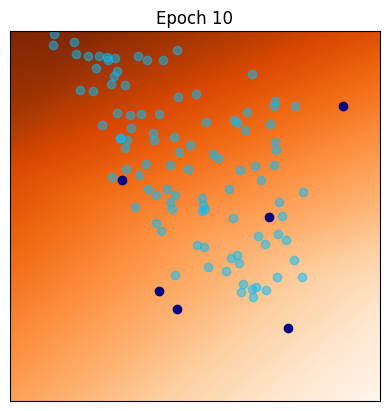

[11/100] 	Loss_D: -0.0214	Loss_G: 0.0100
[12/100] 	Loss_D: -0.0084	Loss_G: 0.0180
[13/100] 	Loss_D: -0.0052	Loss_G: -0.0104
[14/100] 	Loss_D: -0.0051	Loss_G: 0.0370
[15/100] 	Loss_D: -0.0098	Loss_G: 0.0709
[16/100] 	Loss_D: -0.0062	Loss_G: 0.0272
[17/100] 	Loss_D: -0.0000	Loss_G: 0.1034
[18/100] 	Loss_D: -0.0296	Loss_G: 0.1388
[19/100] 	Loss_D: -0.0052	Loss_G: 0.1180
[20/100] 	Loss_D: -0.0021	Loss_G: 0.0964


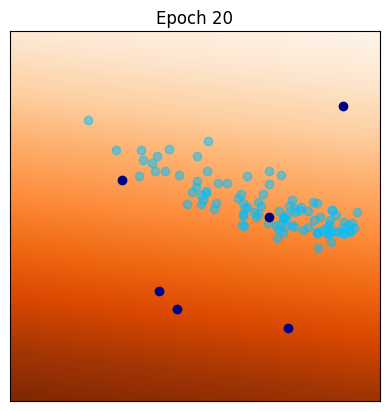

[21/100] 	Loss_D: -0.0163	Loss_G: 0.1370
[22/100] 	Loss_D: -0.0033	Loss_G: 0.1851
[23/100] 	Loss_D: -0.0074	Loss_G: 0.0857
[24/100] 	Loss_D: -0.0075	Loss_G: 0.1584
[25/100] 	Loss_D: -0.0014	Loss_G: 0.1181
[26/100] 	Loss_D: -0.0078	Loss_G: 0.1740
[27/100] 	Loss_D: -0.0086	Loss_G: 0.2069
[28/100] 	Loss_D: -0.0091	Loss_G: 0.1814
[29/100] 	Loss_D: -0.0144	Loss_G: 0.1238
[30/100] 	Loss_D: -0.0064	Loss_G: 0.2071


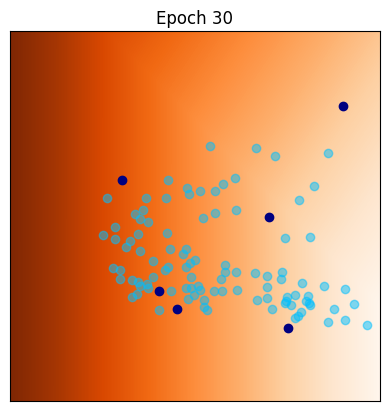

[31/100] 	Loss_D: -0.0047	Loss_G: 0.1939
[32/100] 	Loss_D: -0.0034	Loss_G: 0.1840
[33/100] 	Loss_D: -0.0103	Loss_G: 0.1002
[34/100] 	Loss_D: -0.0005	Loss_G: 0.1364
[35/100] 	Loss_D: -0.0092	Loss_G: 0.2043
[36/100] 	Loss_D: -0.0059	Loss_G: 0.1478
[37/100] 	Loss_D: -0.0012	Loss_G: 0.1529
[38/100] 	Loss_D: -0.0047	Loss_G: 0.1531
[39/100] 	Loss_D: -0.0014	Loss_G: 0.1487
[40/100] 	Loss_D: -0.0065	Loss_G: 0.1512


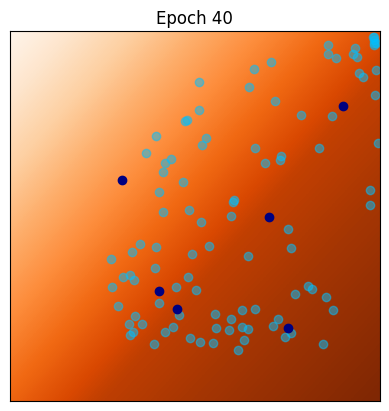

[41/100] 	Loss_D: -0.0056	Loss_G: 0.1498
[42/100] 	Loss_D: -0.0039	Loss_G: 0.0617
[43/100] 	Loss_D: -0.0138	Loss_G: 0.0290
[44/100] 	Loss_D: -0.0067	Loss_G: 0.0288
[45/100] 	Loss_D: -0.0384	Loss_G: 0.0890
[46/100] 	Loss_D: -0.0143	Loss_G: 0.0814
[47/100] 	Loss_D: -0.0000	Loss_G: 0.0920
[48/100] 	Loss_D: -0.0051	Loss_G: 0.0648
[49/100] 	Loss_D: -0.0053	Loss_G: 0.0507
[50/100] 	Loss_D: -0.0006	Loss_G: 0.0488


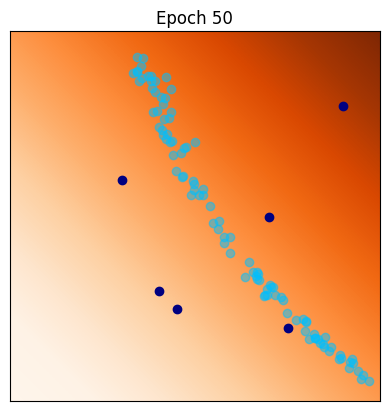

[51/100] 	Loss_D: 0.0001	Loss_G: 0.0979
[52/100] 	Loss_D: -0.0017	Loss_G: 0.1368
[53/100] 	Loss_D: -0.0013	Loss_G: 0.1388
[54/100] 	Loss_D: -0.0004	Loss_G: 0.1404
[55/100] 	Loss_D: 0.0000	Loss_G: 0.0996
[56/100] 	Loss_D: -0.0008	Loss_G: 0.0618
[57/100] 	Loss_D: -0.0009	Loss_G: 0.0493
[58/100] 	Loss_D: 0.0000	Loss_G: 0.1006
[59/100] 	Loss_D: -0.0013	Loss_G: 0.1503
[60/100] 	Loss_D: -0.0005	Loss_G: 0.1492


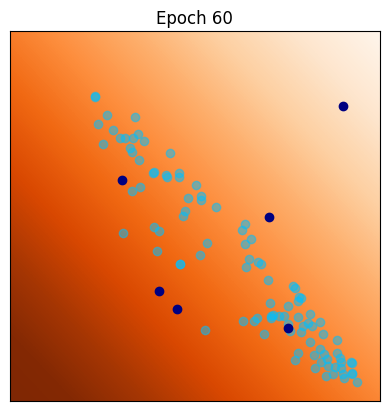

[61/100] 	Loss_D: -0.0000	Loss_G: 0.0953
[62/100] 	Loss_D: -0.0022	Loss_G: 0.0509
[63/100] 	Loss_D: -0.0006	Loss_G: 0.0599
[64/100] 	Loss_D: -0.0024	Loss_G: -0.0015
[65/100] 	Loss_D: -0.0017	Loss_G: 0.0670
[66/100] 	Loss_D: -0.0005	Loss_G: 0.0643
[67/100] 	Loss_D: -0.0012	Loss_G: 0.0003
[68/100] 	Loss_D: -0.0000	Loss_G: 0.1006
[69/100] 	Loss_D: -0.0054	Loss_G: 0.1968
[70/100] 	Loss_D: -0.0012	Loss_G: 0.1649


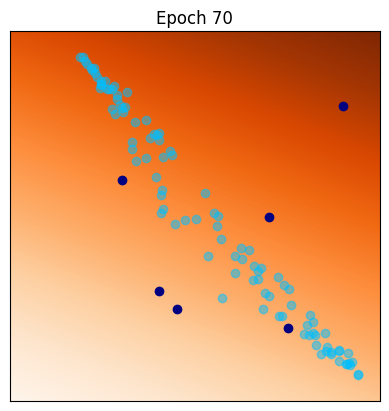

[71/100] 	Loss_D: -0.0053	Loss_G: 0.1326
[72/100] 	Loss_D: -0.0025	Loss_G: 0.1301
[73/100] 	Loss_D: 0.0000	Loss_G: 0.1130
[74/100] 	Loss_D: 0.0000	Loss_G: 0.1015
[75/100] 	Loss_D: 0.0000	Loss_G: 0.1000
[76/100] 	Loss_D: -0.0000	Loss_G: 0.0986
[77/100] 	Loss_D: -0.0036	Loss_G: 0.0756
[78/100] 	Loss_D: -0.0032	Loss_G: 0.0838
[79/100] 	Loss_D: -0.0025	Loss_G: 0.0761
[80/100] 	Loss_D: -0.0017	Loss_G: 0.0780


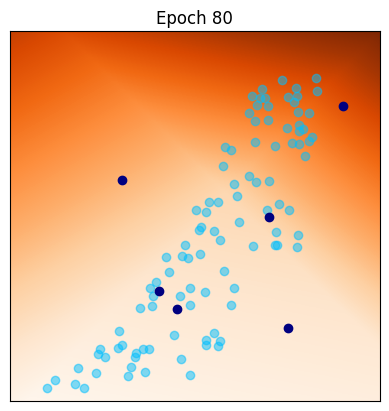

[81/100] 	Loss_D: -0.0009	Loss_G: 0.0813
[82/100] 	Loss_D: -0.0018	Loss_G: 0.0764
[83/100] 	Loss_D: -0.0020	Loss_G: 0.0731
[84/100] 	Loss_D: -0.0032	Loss_G: 0.0795
[85/100] 	Loss_D: -0.0015	Loss_G: 0.0761
[86/100] 	Loss_D: -0.0014	Loss_G: 0.0741
[87/100] 	Loss_D: -0.0014	Loss_G: 0.0741
[88/100] 	Loss_D: -0.0007	Loss_G: 0.0793
[89/100] 	Loss_D: -0.0007	Loss_G: 0.0791
[90/100] 	Loss_D: -0.0007	Loss_G: 0.0799


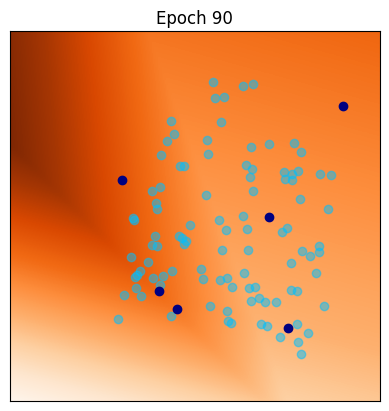

[91/100] 	Loss_D: -0.0006	Loss_G: 0.0802
[92/100] 	Loss_D: -0.0005	Loss_G: 0.0814
[93/100] 	Loss_D: -0.0009	Loss_G: 0.0811
[94/100] 	Loss_D: -0.0006	Loss_G: 0.0815
[95/100] 	Loss_D: -0.0034	Loss_G: 0.1565
[96/100] 	Loss_D: -0.0092	Loss_G: 0.0416
[97/100] 	Loss_D: -0.0038	Loss_G: 0.0382
[98/100] 	Loss_D: -0.0059	Loss_G: 0.0948
[99/100] 	Loss_D: -0.0034	Loss_G: 0.0893


<All keys matched successfully>

In [14]:
lrgen = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for discriminator
## parameters for training
n_epochs = 100
niterD=400
niterG=30

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lrgen)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

clip_value = .1
iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    Gloss = torch.tensor(0.0, device=device)
    Dloss = torch.tensor(0.0, device=device)
    for iter in range(0,niterD):
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        optimD.zero_grad()
        Dloss = torch.mean(D(x)) - torch.mean(D(y))
        Dloss.backward()
        optimD.step()
        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        optimG.zero_grad()
        Gloss = -torch.mean(D(x))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())

## Estimate the Lipschitz constant of the discriminator

QUESTION: Implement a function computing an estimation of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

Use this function to examine the Lipschitz constant of the final discriminator obtained with WGAN-WC.

In [15]:
def lipconstant(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    # Calculate discriminator on interpolated examples
    Di = D(interp)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=Di, inputs=interp,
                              grad_outputs=torch.ones_like(Di),
                              create_graph=True, retain_graph=False)[0]

    # add epsilon to avoid instabilities
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-8)

    return torch.mean(gradients_norm)

#### (lip constant of the current D) ###

lipconstant(D,y,y)

tensor(0.0462, grad_fn=<MeanBackward0>)

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of $D$ on points that are interpolated between $x$ and $y$.

In [16]:
def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    Di = D(interp)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=Di, inputs=interp,
                              grad_outputs=torch.ones_like(Di),
                              create_graph=True, retain_graph=True)[0] ##Retain graph for loss.backward()

    gradients_norm_2 = torch.sum(gradients ** 2, dim=1)

    return torch.mean((gradients_norm_2 - 1) ** 2)


## Train the WGAN-GP discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\leq 1$.

[0/1000], 0.954303


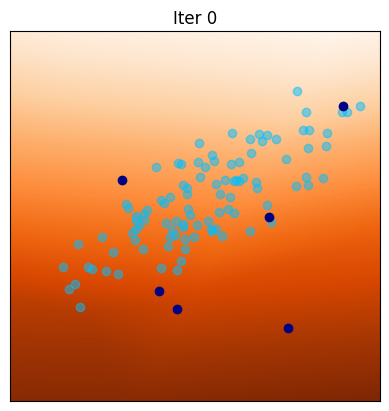

[100/1000], -0.113049


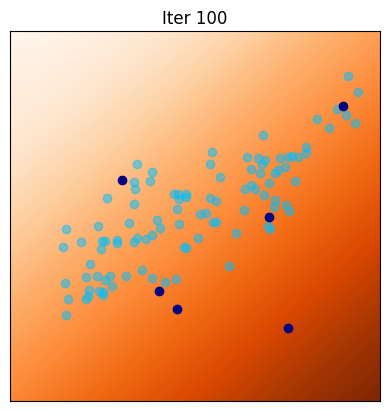

[200/1000], -0.117041


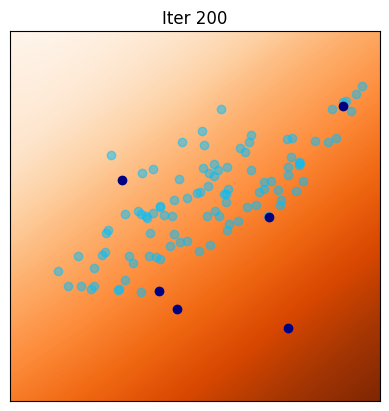

[300/1000], -0.119060


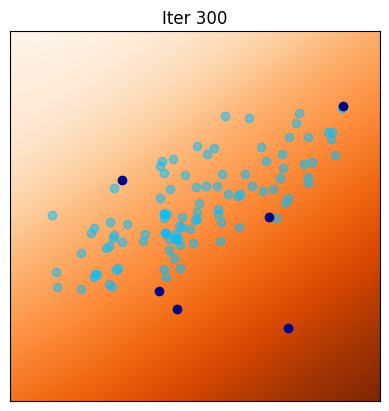

[400/1000], -0.107229


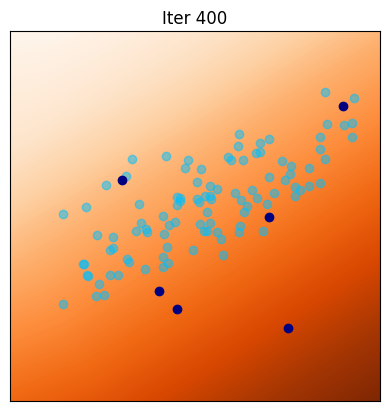

[500/1000], -0.103900


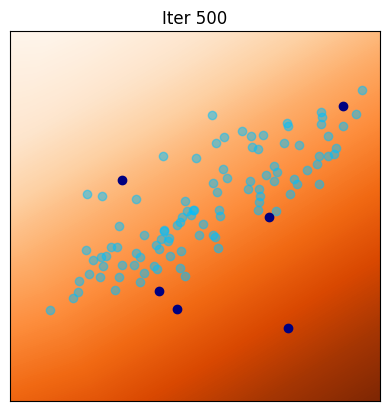

[600/1000], -0.110808


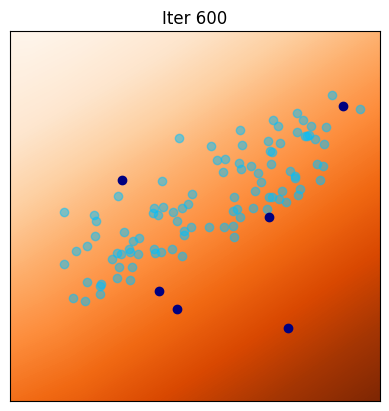

[700/1000], -0.110377


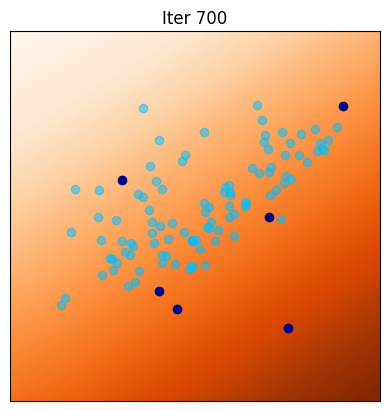

[800/1000], -0.118763


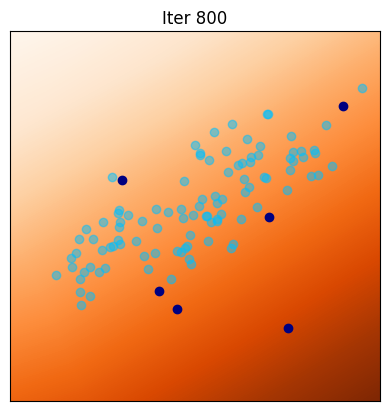

[900/1000], -0.119622


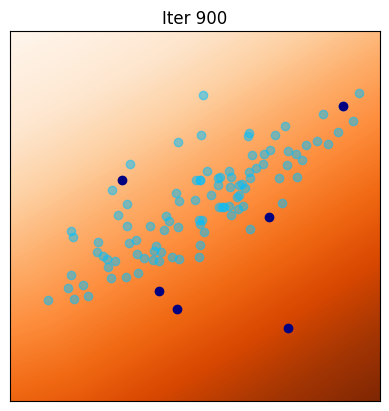

In [17]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Reinitialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lrgen)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 1
niterD=1000

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    # Generate batch of fake points
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    # Compute the loss
    Dloss = torch.mean(D(x)) - torch.mean(D(y)) + gpw * gradient_penalty(D,x,y)
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

Final estimated Lipschitz constant =  1.0129785537719727


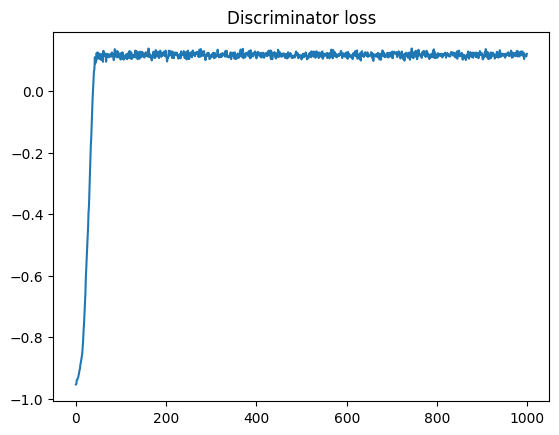

In [18]:
print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

QUESTION: Learn both generator and discriminator with the gradient penalty term

[0/400] 	Loss_D: -0.1340	Loss_G: -0.6143


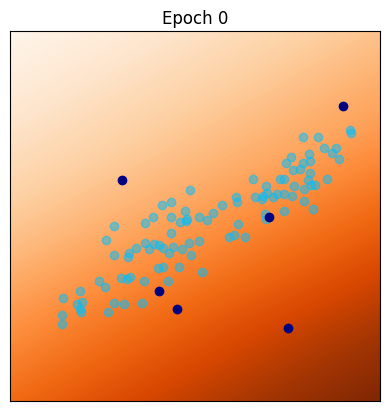

[1/400] 	Loss_D: -0.0668	Loss_G: -0.8005
[2/400] 	Loss_D: -0.0650	Loss_G: -1.0057
[3/400] 	Loss_D: -0.0746	Loss_G: -0.6546
[4/400] 	Loss_D: -0.1389	Loss_G: -0.3588
[5/400] 	Loss_D: -0.0920	Loss_G: -0.5322
[6/400] 	Loss_D: -0.0141	Loss_G: -0.8106
[7/400] 	Loss_D: -0.0936	Loss_G: -1.7480
[8/400] 	Loss_D: -0.1785	Loss_G: -1.6961
[9/400] 	Loss_D: -0.1782	Loss_G: -1.8577
[10/400] 	Loss_D: -0.1553	Loss_G: -1.9131
[11/400] 	Loss_D: -0.0979	Loss_G: -1.8215
[12/400] 	Loss_D: -0.1256	Loss_G: -2.3985
[13/400] 	Loss_D: -0.0769	Loss_G: -2.5917
[14/400] 	Loss_D: -0.0099	Loss_G: -2.7142
[15/400] 	Loss_D: 0.0244	Loss_G: -2.8298
[16/400] 	Loss_D: -0.0006	Loss_G: -3.0222
[17/400] 	Loss_D: -0.0924	Loss_G: -2.7652
[18/400] 	Loss_D: -0.0884	Loss_G: -2.3490
[19/400] 	Loss_D: -0.0256	Loss_G: -1.5566
[20/400] 	Loss_D: -0.0363	Loss_G: -1.6429
[21/400] 	Loss_D: -0.0895	Loss_G: -2.6101
[22/400] 	Loss_D: -0.0738	Loss_G: -2.8311
[23/400] 	Loss_D: -0.0733	Loss_G: -3.0371
[24/400] 	Loss_D: -0.0851	Loss_G: -3.3293
[2

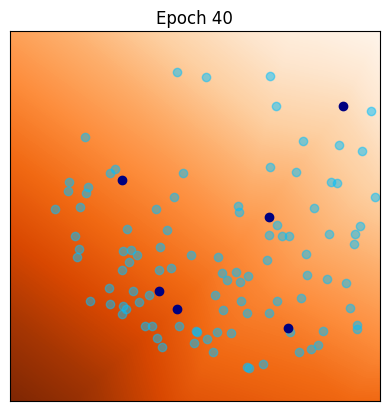

[41/400] 	Loss_D: -0.0039	Loss_G: -4.8398
[42/400] 	Loss_D: -0.1150	Loss_G: -3.7217
[43/400] 	Loss_D: -0.1172	Loss_G: -3.1072
[44/400] 	Loss_D: -0.0988	Loss_G: -2.1936
[45/400] 	Loss_D: -0.0578	Loss_G: -1.8523
[46/400] 	Loss_D: -0.0424	Loss_G: -1.1747
[47/400] 	Loss_D: -0.0511	Loss_G: -1.4741
[48/400] 	Loss_D: -0.0225	Loss_G: -3.0344
[49/400] 	Loss_D: -0.0885	Loss_G: -4.5143
[50/400] 	Loss_D: -0.1104	Loss_G: -4.6701
[51/400] 	Loss_D: -0.0623	Loss_G: -4.2039
[52/400] 	Loss_D: -0.0944	Loss_G: -3.6762
[53/400] 	Loss_D: -0.0431	Loss_G: -3.1429
[54/400] 	Loss_D: -0.0373	Loss_G: -1.7871
[55/400] 	Loss_D: -0.1434	Loss_G: -2.0900
[56/400] 	Loss_D: -0.1394	Loss_G: -2.3462
[57/400] 	Loss_D: -0.0905	Loss_G: -2.3072
[58/400] 	Loss_D: -0.0491	Loss_G: -2.2932
[59/400] 	Loss_D: -0.0438	Loss_G: -2.5707
[60/400] 	Loss_D: -0.0895	Loss_G: -2.6336
[61/400] 	Loss_D: -0.0860	Loss_G: -3.6263
[62/400] 	Loss_D: -0.0898	Loss_G: -4.2316
[63/400] 	Loss_D: -0.0956	Loss_G: -5.0663
[64/400] 	Loss_D: -0.0538	Loss_G: 

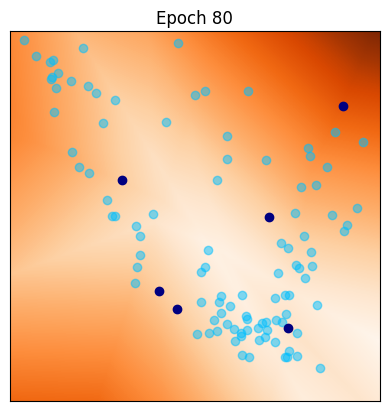

[81/400] 	Loss_D: -0.0860	Loss_G: -8.5862
[82/400] 	Loss_D: -0.0876	Loss_G: -9.1140
[83/400] 	Loss_D: -0.0766	Loss_G: -9.7272
[84/400] 	Loss_D: -0.0906	Loss_G: -8.9057
[85/400] 	Loss_D: -0.1014	Loss_G: -8.6715
[86/400] 	Loss_D: -0.0539	Loss_G: -9.5414
[87/400] 	Loss_D: -0.0885	Loss_G: -10.4528
[88/400] 	Loss_D: -0.0927	Loss_G: -10.1868
[89/400] 	Loss_D: -0.0793	Loss_G: -10.4450
[90/400] 	Loss_D: -0.0551	Loss_G: -11.3804
[91/400] 	Loss_D: -0.0588	Loss_G: -12.4882
[92/400] 	Loss_D: -0.0788	Loss_G: -12.8620
[93/400] 	Loss_D: -0.0954	Loss_G: -12.3475
[94/400] 	Loss_D: -0.0698	Loss_G: -12.4730
[95/400] 	Loss_D: -0.0759	Loss_G: -12.7936
[96/400] 	Loss_D: -0.0838	Loss_G: -12.6042
[97/400] 	Loss_D: -0.0769	Loss_G: -12.7519
[98/400] 	Loss_D: -0.0752	Loss_G: -13.2546
[99/400] 	Loss_D: -0.0639	Loss_G: -14.1054
[100/400] 	Loss_D: -0.0664	Loss_G: -14.6505
[101/400] 	Loss_D: -0.0701	Loss_G: -14.9328
[102/400] 	Loss_D: -0.0776	Loss_G: -15.0136
[103/400] 	Loss_D: -0.0776	Loss_G: -14.9754
[104/400] 	Lo

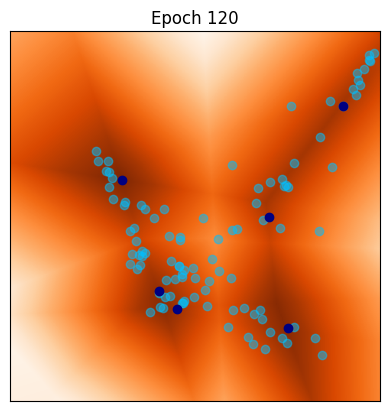

[121/400] 	Loss_D: -0.0640	Loss_G: -16.7085
[122/400] 	Loss_D: -0.0575	Loss_G: -16.7558
[123/400] 	Loss_D: -0.0595	Loss_G: -16.8350
[124/400] 	Loss_D: -0.0618	Loss_G: -16.7348
[125/400] 	Loss_D: -0.0572	Loss_G: -16.9865
[126/400] 	Loss_D: -0.0578	Loss_G: -17.1163
[127/400] 	Loss_D: -0.0545	Loss_G: -17.1854
[128/400] 	Loss_D: -0.0460	Loss_G: -17.3761
[129/400] 	Loss_D: -0.0554	Loss_G: -17.2204
[130/400] 	Loss_D: -0.0499	Loss_G: -17.2264
[131/400] 	Loss_D: -0.0503	Loss_G: -17.4436
[132/400] 	Loss_D: -0.0569	Loss_G: -17.6296
[133/400] 	Loss_D: -0.0622	Loss_G: -17.6267
[134/400] 	Loss_D: -0.0530	Loss_G: -17.5828
[135/400] 	Loss_D: -0.0522	Loss_G: -17.7985
[136/400] 	Loss_D: -0.0551	Loss_G: -18.0617
[137/400] 	Loss_D: -0.0617	Loss_G: -17.8371
[138/400] 	Loss_D: -0.0467	Loss_G: -18.0958
[139/400] 	Loss_D: -0.0563	Loss_G: -18.0854
[140/400] 	Loss_D: -0.0589	Loss_G: -17.8203
[141/400] 	Loss_D: -0.0529	Loss_G: -17.6498
[142/400] 	Loss_D: -0.0487	Loss_G: -17.8324
[143/400] 	Loss_D: -0.0545	Loss_

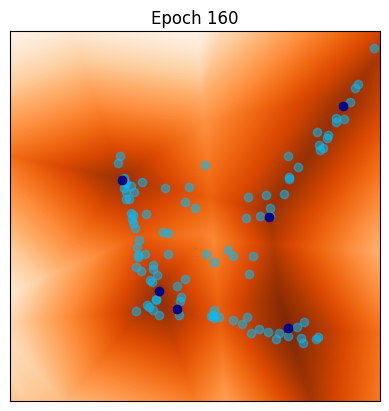

[161/400] 	Loss_D: -0.0486	Loss_G: -17.7590
[162/400] 	Loss_D: -0.0516	Loss_G: -17.5881
[163/400] 	Loss_D: -0.0600	Loss_G: -17.3507
[164/400] 	Loss_D: -0.0379	Loss_G: -17.7688
[165/400] 	Loss_D: -0.0547	Loss_G: -18.1173
[166/400] 	Loss_D: -0.0528	Loss_G: -18.3376
[167/400] 	Loss_D: -0.0517	Loss_G: -18.2938
[168/400] 	Loss_D: -0.0530	Loss_G: -18.3044
[169/400] 	Loss_D: -0.0488	Loss_G: -17.7839
[170/400] 	Loss_D: -0.0569	Loss_G: -17.9233
[171/400] 	Loss_D: -0.0569	Loss_G: -18.3707
[172/400] 	Loss_D: -0.0547	Loss_G: -18.2617
[173/400] 	Loss_D: -0.0467	Loss_G: -17.8409
[174/400] 	Loss_D: -0.0436	Loss_G: -17.7626
[175/400] 	Loss_D: -0.0451	Loss_G: -17.9151
[176/400] 	Loss_D: -0.0516	Loss_G: -18.1672
[177/400] 	Loss_D: -0.0573	Loss_G: -18.5325
[178/400] 	Loss_D: -0.0531	Loss_G: -18.0462
[179/400] 	Loss_D: -0.0469	Loss_G: -17.9687
[180/400] 	Loss_D: -0.0498	Loss_G: -17.8450
[181/400] 	Loss_D: -0.0543	Loss_G: -17.5088
[182/400] 	Loss_D: -0.0507	Loss_G: -17.7039
[183/400] 	Loss_D: -0.0582	Loss_

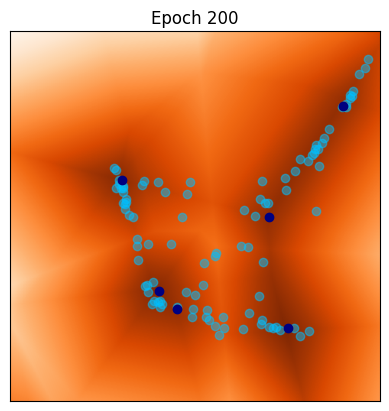

[201/400] 	Loss_D: -0.0544	Loss_G: -17.6739
[202/400] 	Loss_D: -0.0622	Loss_G: -17.3488
[203/400] 	Loss_D: -0.0497	Loss_G: -17.1152
[204/400] 	Loss_D: -0.0463	Loss_G: -17.5104
[205/400] 	Loss_D: -0.0569	Loss_G: -17.9310
[206/400] 	Loss_D: -0.0485	Loss_G: -17.6817
[207/400] 	Loss_D: -0.0505	Loss_G: -18.0743
[208/400] 	Loss_D: -0.0479	Loss_G: -17.6085
[209/400] 	Loss_D: -0.0561	Loss_G: -17.6504
[210/400] 	Loss_D: -0.0478	Loss_G: -17.4812
[211/400] 	Loss_D: -0.0540	Loss_G: -17.6261
[212/400] 	Loss_D: -0.0496	Loss_G: -17.5947
[213/400] 	Loss_D: -0.0502	Loss_G: -17.7816
[214/400] 	Loss_D: -0.0464	Loss_G: -18.1254
[215/400] 	Loss_D: -0.0445	Loss_G: -18.3132
[216/400] 	Loss_D: -0.0469	Loss_G: -18.1376
[217/400] 	Loss_D: -0.0527	Loss_G: -17.8938
[218/400] 	Loss_D: -0.0519	Loss_G: -18.0129
[219/400] 	Loss_D: -0.0494	Loss_G: -17.6994
[220/400] 	Loss_D: -0.0480	Loss_G: -18.1896
[221/400] 	Loss_D: -0.0450	Loss_G: -17.9126
[222/400] 	Loss_D: -0.0500	Loss_G: -18.0231
[223/400] 	Loss_D: -0.0550	Loss_

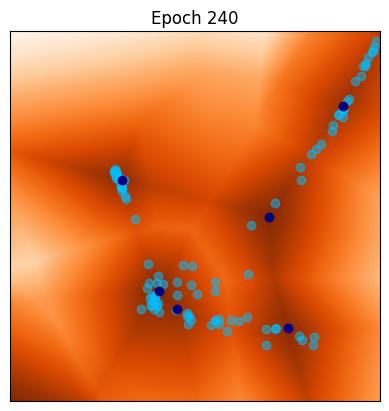

[241/400] 	Loss_D: -0.0507	Loss_G: -16.1844
[242/400] 	Loss_D: -0.0553	Loss_G: -15.9255
[243/400] 	Loss_D: -0.0488	Loss_G: -15.7422
[244/400] 	Loss_D: -0.0492	Loss_G: -16.0029
[245/400] 	Loss_D: -0.0571	Loss_G: -15.5444
[246/400] 	Loss_D: -0.0494	Loss_G: -16.1274
[247/400] 	Loss_D: -0.0559	Loss_G: -15.0739
[248/400] 	Loss_D: -0.0481	Loss_G: -15.5604
[249/400] 	Loss_D: -0.0538	Loss_G: -15.5937
[250/400] 	Loss_D: -0.0523	Loss_G: -15.5375
[251/400] 	Loss_D: -0.0498	Loss_G: -16.1014
[252/400] 	Loss_D: -0.0438	Loss_G: -15.4974
[253/400] 	Loss_D: -0.0503	Loss_G: -15.5838
[254/400] 	Loss_D: -0.0484	Loss_G: -15.2225
[255/400] 	Loss_D: -0.0503	Loss_G: -15.7718
[256/400] 	Loss_D: -0.0545	Loss_G: -16.3309
[257/400] 	Loss_D: -0.0582	Loss_G: -15.7042
[258/400] 	Loss_D: -0.0632	Loss_G: -16.5694
[259/400] 	Loss_D: -0.0632	Loss_G: -15.3793
[260/400] 	Loss_D: -0.0438	Loss_G: -16.0688
[261/400] 	Loss_D: -0.0505	Loss_G: -16.8188
[262/400] 	Loss_D: -0.0438	Loss_G: -17.1599
[263/400] 	Loss_D: -0.0559	Loss_

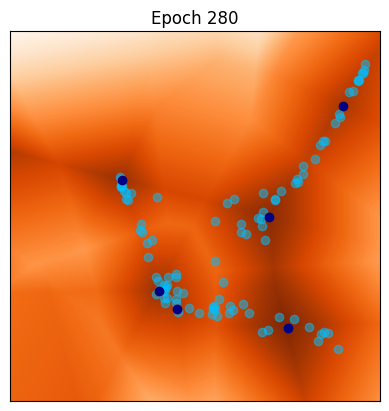

[281/400] 	Loss_D: -0.0547	Loss_G: -18.6814
[282/400] 	Loss_D: -0.0489	Loss_G: -19.0722
[283/400] 	Loss_D: -0.0533	Loss_G: -19.5030
[284/400] 	Loss_D: -0.0469	Loss_G: -20.1471
[285/400] 	Loss_D: -0.0455	Loss_G: -18.7340
[286/400] 	Loss_D: -0.0364	Loss_G: -19.1250
[287/400] 	Loss_D: -0.0403	Loss_G: -19.9014
[288/400] 	Loss_D: -0.0470	Loss_G: -20.4778
[289/400] 	Loss_D: -0.0477	Loss_G: -19.5222
[290/400] 	Loss_D: -0.0457	Loss_G: -20.0713
[291/400] 	Loss_D: -0.0518	Loss_G: -20.1450
[292/400] 	Loss_D: -0.0491	Loss_G: -19.2454
[293/400] 	Loss_D: -0.0543	Loss_G: -18.8108
[294/400] 	Loss_D: -0.0603	Loss_G: -18.9369
[295/400] 	Loss_D: -0.0462	Loss_G: -17.4244
[296/400] 	Loss_D: -0.0586	Loss_G: -18.4093
[297/400] 	Loss_D: -0.0612	Loss_G: -18.2094
[298/400] 	Loss_D: -0.0586	Loss_G: -19.1294
[299/400] 	Loss_D: -0.0521	Loss_G: -17.5760
[300/400] 	Loss_D: -0.0571	Loss_G: -18.1993
[301/400] 	Loss_D: -0.0588	Loss_G: -17.8059
[302/400] 	Loss_D: -0.0565	Loss_G: -18.5461
[303/400] 	Loss_D: -0.0590	Loss_

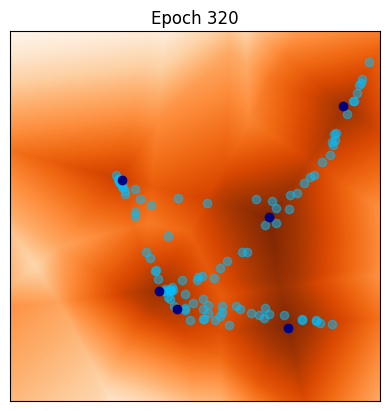

[321/400] 	Loss_D: -0.0590	Loss_G: -17.5994
[322/400] 	Loss_D: -0.0599	Loss_G: -17.2265
[323/400] 	Loss_D: -0.0512	Loss_G: -18.0093
[324/400] 	Loss_D: -0.0495	Loss_G: -18.6948
[325/400] 	Loss_D: -0.0545	Loss_G: -18.9940
[326/400] 	Loss_D: -0.0511	Loss_G: -19.4720
[327/400] 	Loss_D: -0.0582	Loss_G: -19.4181
[328/400] 	Loss_D: -0.0586	Loss_G: -19.3489
[329/400] 	Loss_D: -0.0686	Loss_G: -19.5294
[330/400] 	Loss_D: -0.0594	Loss_G: -20.0640
[331/400] 	Loss_D: -0.0523	Loss_G: -20.3242
[332/400] 	Loss_D: -0.0609	Loss_G: -20.4224
[333/400] 	Loss_D: -0.0590	Loss_G: -19.8407
[334/400] 	Loss_D: -0.0496	Loss_G: -20.4576
[335/400] 	Loss_D: -0.0530	Loss_G: -21.0430
[336/400] 	Loss_D: -0.0458	Loss_G: -21.8672
[337/400] 	Loss_D: -0.0519	Loss_G: -21.5426
[338/400] 	Loss_D: -0.0556	Loss_G: -21.4162
[339/400] 	Loss_D: -0.0579	Loss_G: -22.0136
[340/400] 	Loss_D: -0.0594	Loss_G: -22.6010
[341/400] 	Loss_D: -0.0566	Loss_G: -21.4700
[342/400] 	Loss_D: -0.0410	Loss_G: -22.1035
[343/400] 	Loss_D: -0.0449	Loss_

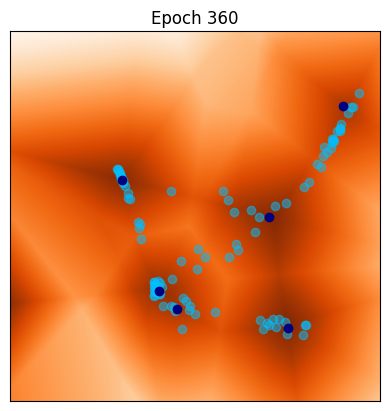

[361/400] 	Loss_D: -0.0551	Loss_G: -26.7700
[362/400] 	Loss_D: -0.0343	Loss_G: -27.4724
[363/400] 	Loss_D: -0.0596	Loss_G: -28.4356
[364/400] 	Loss_D: -0.0664	Loss_G: -27.4717
[365/400] 	Loss_D: -0.0503	Loss_G: -27.1680
[366/400] 	Loss_D: -0.0503	Loss_G: -27.7583
[367/400] 	Loss_D: -0.0502	Loss_G: -29.8191
[368/400] 	Loss_D: -0.0652	Loss_G: -29.2853
[369/400] 	Loss_D: -0.0522	Loss_G: -29.1209
[370/400] 	Loss_D: -0.0533	Loss_G: -28.3796
[371/400] 	Loss_D: -0.0568	Loss_G: -29.4381
[372/400] 	Loss_D: -0.0667	Loss_G: -30.4279
[373/400] 	Loss_D: -0.0684	Loss_G: -30.4211
[374/400] 	Loss_D: -0.0508	Loss_G: -30.2354
[375/400] 	Loss_D: -0.0478	Loss_G: -29.2018
[376/400] 	Loss_D: -0.0495	Loss_G: -31.0496
[377/400] 	Loss_D: -0.0570	Loss_G: -31.1808
[378/400] 	Loss_D: -0.0416	Loss_G: -31.6871
[379/400] 	Loss_D: -0.0487	Loss_G: -30.8640
[380/400] 	Loss_D: -0.0618	Loss_G: -31.0293
[381/400] 	Loss_D: -0.0563	Loss_G: -30.6406
[382/400] 	Loss_D: -0.0527	Loss_G: -31.6398
[383/400] 	Loss_D: -0.0586	Loss_

<All keys matched successfully>

In [19]:
lrgen = 0.002   # learning rate for generator

## parameters for training
n_epochs = 400
niterD=1000
niterG=10

lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 0.1
niterD=100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lrgen)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 40

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    Gloss = torch.tensor(0.0, device=device)
    Dloss = torch.tensor(0.0, device=device)
    for iter in range(0,niterD):
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        optimD.zero_grad()
        Dloss = torch.mean(D(x)) - torch.mean(D(y))
        Dloss = Dloss + gpw * gradient_penalty(D,x,y)
        Dloss.backward()
        optimD.step()


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        optimG.zero_grad()
        Gloss = -torch.mean(D(x))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# Exercise 3: Learn a semi-discrete WGAN (with c-transform)

In this exercise, we will learn a WGAN with semi-discrete OT for the cost $c(x,y) = \|x-y\|^p$.

QUESTION: Implement the c-transform parameterized by the vector $v = (\psi(y_j))_{1 \leq j \leq n}$ ($\psi$ is the dual variable of the optimal transport cost).

The c-transform should apply to a batch of points x.

In [20]:
# Recall the shape of the tensors at play:
#   x   (b , d)
#   y   (n,  d)
#   v   (n)
#
# In other words:
#   b: number of generated points (i.e. batch size)
#   n: number of data points
#   d: dimension of the data

def ctransform(x,y,v, p=2):
    rmv = torch.cdist(x.unsqueeze(0),y.unsqueeze(0),p=p)**p - v[None,:]
    return torch.min(rmv,-1)[0]

# Discriminator loss with the c-transform parameterization:
def lossdisc(x,y,v,nu):
    return - ctransform(x,y,v).mean() - torch.sum(v*nu)

# function for plotting the Laguerre diagram
def transport_and_color(x,y,v,p=2):
    rmv = torch.cdist(x.unsqueeze(0),y.unsqueeze(0),p=p)**p - v[None,:]
    j = torch.argmin(rmv,-1)
    return y[j,:],j

QUESTION: Display the c-transform for $v=0$ (computed on `xgrid`) and the corresponding Laguerre diagram.

torch.Size([1, 65536])


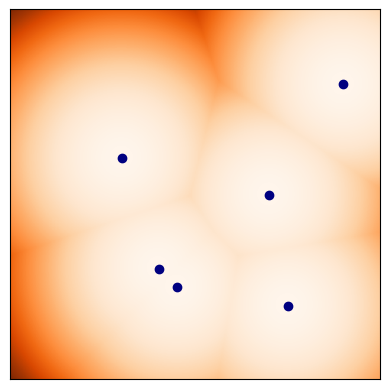

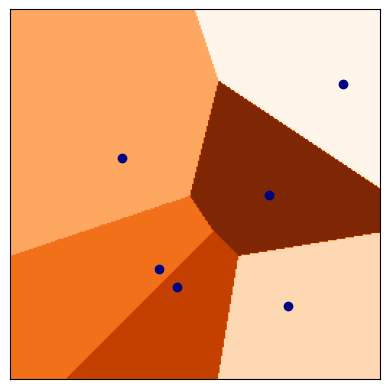

In [21]:
v = torch.zeros(n).to(device)

# c-transform
psix = ctransform(xgrid,y,v)
print(psix.shape)
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(psix.detach().cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()


# Laguerre diagram
Tx,cx = transport_and_color(xgrid,y,v.detach())
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(cx.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()


## Plot optimal c-transform for fixed generator

QUESTION: Complete the following code at the blocks ###...###.

The dual variable `v` should be optimized in order to approximate the solution of semi-discrete optimal transport.

[200/1000], -0.047265


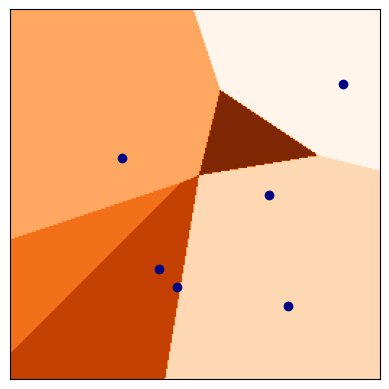

[400/1000], -0.047680


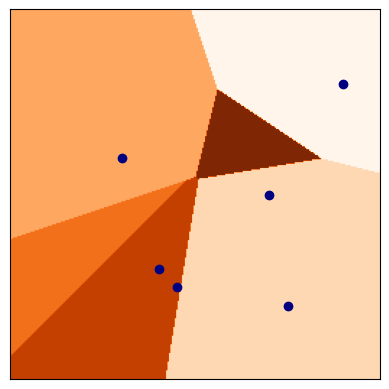

[600/1000], -0.047265


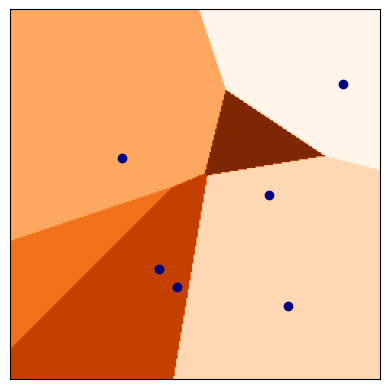

[800/1000], -0.045267


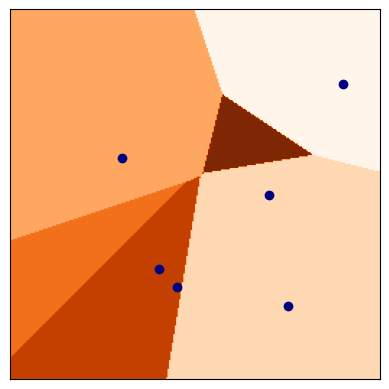

In [22]:
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

v = torch.zeros(n, device=device, requires_grad=True)
all_params = [v]
optimD = optim.Adam(all_params, lr=lrdisc, betas=(beta_1, beta_2))
niterD=1000
Dlosses = []

iter_display = 200

for iter in range(1,niterD):

        ### UPDATE OF D ###
        optimD.zero_grad()
        # Generate batch of fake points
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        # Compute the loss
        Dloss = lossdisc(x,y,v,nu)
        Dloss.backward()
        optimD.step()

        ### SAVE LOSS ###
        Dlosst = Dloss.item()
        Dlosses.append(-Dlosst)

        if(iter%iter_display == 0):
            print('[%d/%d], %f' % (iter, niterD, Dlosst))
            Tx,cx = transport_and_color(xgrid,y,v.detach())
            fig = plt.figure(dpi=100)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(cx.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
            plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
            plt.show()

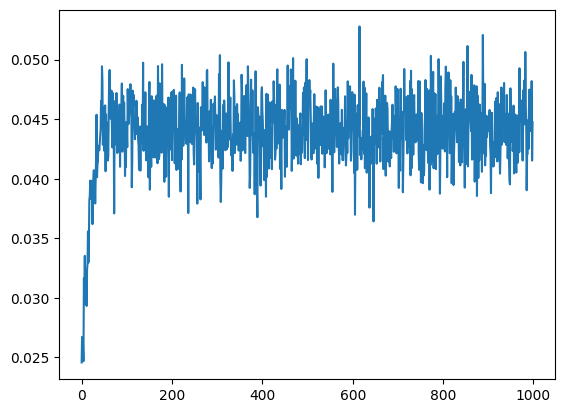

In [23]:
plt.plot(Dlosses)

## Train both the Generator and Discriminator

In this question, we will train the generator in order to optimize a WGAN with the semi-discrete formulation (involving the c-transform).

QUESTION: Complete the following code at the blocks ###...###.

[1/200] 	Loss_D: -0.0473	Loss_G: 0.0356
[2/200] 	Loss_D: -0.0369	Loss_G: 0.0294
[3/200] 	Loss_D: -0.0270	Loss_G: 0.0161
[4/200] 	Loss_D: -0.0246	Loss_G: 0.0235
[5/200] 	Loss_D: -0.0208	Loss_G: 0.0179
[6/200] 	Loss_D: -0.0193	Loss_G: 0.0181
[7/200] 	Loss_D: -0.0217	Loss_G: 0.0229
[8/200] 	Loss_D: -0.0190	Loss_G: 0.0187
[9/200] 	Loss_D: -0.0188	Loss_G: 0.0207
[10/200] 	Loss_D: -0.0182	Loss_G: 0.0177
[11/200] 	Loss_D: -0.0130	Loss_G: 0.0160
[12/200] 	Loss_D: -0.0185	Loss_G: 0.0177
[13/200] 	Loss_D: -0.0141	Loss_G: 0.0149
[14/200] 	Loss_D: -0.0212	Loss_G: 0.0187
[15/200] 	Loss_D: -0.0157	Loss_G: 0.0149
[16/200] 	Loss_D: -0.0172	Loss_G: 0.0101
[17/200] 	Loss_D: -0.0111	Loss_G: 0.0126
[18/200] 	Loss_D: -0.0118	Loss_G: 0.0150
[19/200] 	Loss_D: -0.0170	Loss_G: 0.0097
[20/200] 	Loss_D: -0.0216	Loss_G: 0.0160


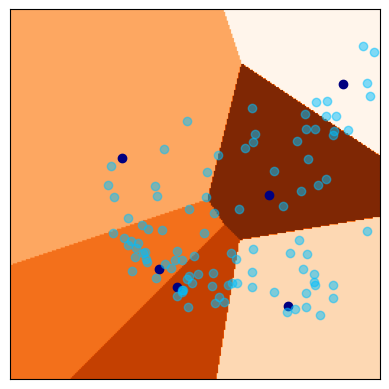

[21/200] 	Loss_D: -0.0143	Loss_G: 0.0126
[22/200] 	Loss_D: -0.0153	Loss_G: 0.0167
[23/200] 	Loss_D: -0.0135	Loss_G: 0.0102
[24/200] 	Loss_D: -0.0238	Loss_G: 0.0149
[25/200] 	Loss_D: -0.0153	Loss_G: 0.0103
[26/200] 	Loss_D: -0.0230	Loss_G: 0.0139
[27/200] 	Loss_D: -0.0099	Loss_G: 0.0112
[28/200] 	Loss_D: -0.0113	Loss_G: 0.0110
[29/200] 	Loss_D: -0.0174	Loss_G: 0.0094
[30/200] 	Loss_D: -0.0139	Loss_G: 0.0155
[31/200] 	Loss_D: -0.0199	Loss_G: 0.0074
[32/200] 	Loss_D: -0.0098	Loss_G: 0.0116
[33/200] 	Loss_D: -0.0256	Loss_G: 0.0092
[34/200] 	Loss_D: -0.0138	Loss_G: 0.0125
[35/200] 	Loss_D: -0.0159	Loss_G: 0.0103
[36/200] 	Loss_D: -0.0143	Loss_G: 0.0150
[37/200] 	Loss_D: -0.0164	Loss_G: 0.0129
[38/200] 	Loss_D: -0.0103	Loss_G: 0.0155
[39/200] 	Loss_D: -0.0136	Loss_G: 0.0108
[40/200] 	Loss_D: -0.0117	Loss_G: 0.0114


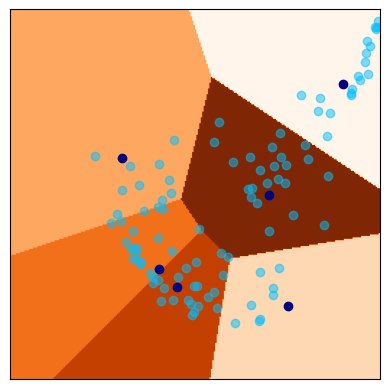

[41/200] 	Loss_D: -0.0186	Loss_G: 0.0120
[42/200] 	Loss_D: -0.0122	Loss_G: 0.0111
[43/200] 	Loss_D: -0.0136	Loss_G: 0.0108
[44/200] 	Loss_D: -0.0138	Loss_G: 0.0059
[45/200] 	Loss_D: -0.0119	Loss_G: 0.0126
[46/200] 	Loss_D: -0.0088	Loss_G: 0.0119
[47/200] 	Loss_D: -0.0129	Loss_G: 0.0117
[48/200] 	Loss_D: -0.0091	Loss_G: 0.0109
[49/200] 	Loss_D: -0.0108	Loss_G: 0.0125
[50/200] 	Loss_D: -0.0117	Loss_G: 0.0105
[51/200] 	Loss_D: -0.0105	Loss_G: 0.0116
[52/200] 	Loss_D: -0.0097	Loss_G: 0.0065
[53/200] 	Loss_D: -0.0063	Loss_G: 0.0140
[54/200] 	Loss_D: -0.0108	Loss_G: 0.0081
[55/200] 	Loss_D: -0.0141	Loss_G: 0.0062
[56/200] 	Loss_D: -0.0126	Loss_G: 0.0083
[57/200] 	Loss_D: -0.0076	Loss_G: 0.0110
[58/200] 	Loss_D: -0.0112	Loss_G: 0.0096
[59/200] 	Loss_D: -0.0135	Loss_G: 0.0115
[60/200] 	Loss_D: -0.0102	Loss_G: 0.0091


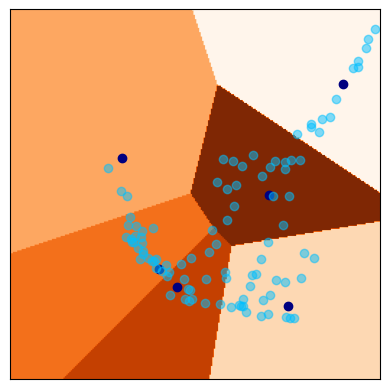

[61/200] 	Loss_D: -0.0132	Loss_G: 0.0073
[62/200] 	Loss_D: -0.0125	Loss_G: 0.0121
[63/200] 	Loss_D: -0.0112	Loss_G: 0.0079
[64/200] 	Loss_D: -0.0091	Loss_G: 0.0124
[65/200] 	Loss_D: -0.0106	Loss_G: 0.0117
[66/200] 	Loss_D: -0.0097	Loss_G: 0.0092
[67/200] 	Loss_D: -0.0109	Loss_G: 0.0122
[68/200] 	Loss_D: -0.0098	Loss_G: 0.0087
[69/200] 	Loss_D: -0.0093	Loss_G: 0.0060
[70/200] 	Loss_D: -0.0131	Loss_G: 0.0087
[71/200] 	Loss_D: -0.0089	Loss_G: 0.0141
[72/200] 	Loss_D: -0.0125	Loss_G: 0.0108
[73/200] 	Loss_D: -0.0096	Loss_G: 0.0106
[74/200] 	Loss_D: -0.0112	Loss_G: 0.0099
[75/200] 	Loss_D: -0.0114	Loss_G: 0.0087
[76/200] 	Loss_D: -0.0091	Loss_G: 0.0081
[77/200] 	Loss_D: -0.0112	Loss_G: 0.0079
[78/200] 	Loss_D: -0.0084	Loss_G: 0.0094
[79/200] 	Loss_D: -0.0092	Loss_G: 0.0095
[80/200] 	Loss_D: -0.0108	Loss_G: 0.0093


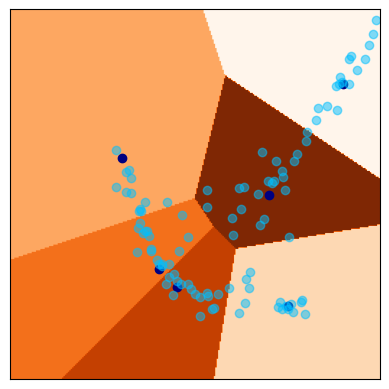

[81/200] 	Loss_D: -0.0093	Loss_G: 0.0080
[82/200] 	Loss_D: -0.0090	Loss_G: 0.0099
[83/200] 	Loss_D: -0.0102	Loss_G: 0.0080
[84/200] 	Loss_D: -0.0088	Loss_G: 0.0064
[85/200] 	Loss_D: -0.0077	Loss_G: 0.0117
[86/200] 	Loss_D: -0.0081	Loss_G: 0.0093
[87/200] 	Loss_D: -0.0112	Loss_G: 0.0074
[88/200] 	Loss_D: -0.0088	Loss_G: 0.0101
[89/200] 	Loss_D: -0.0104	Loss_G: 0.0097
[90/200] 	Loss_D: -0.0130	Loss_G: 0.0112
[91/200] 	Loss_D: -0.0101	Loss_G: 0.0084
[92/200] 	Loss_D: -0.0125	Loss_G: 0.0073
[93/200] 	Loss_D: -0.0075	Loss_G: 0.0095
[94/200] 	Loss_D: -0.0108	Loss_G: 0.0077
[95/200] 	Loss_D: -0.0068	Loss_G: 0.0087
[96/200] 	Loss_D: -0.0093	Loss_G: 0.0073
[97/200] 	Loss_D: -0.0093	Loss_G: 0.0098
[98/200] 	Loss_D: -0.0097	Loss_G: 0.0084
[99/200] 	Loss_D: -0.0101	Loss_G: 0.0085
[100/200] 	Loss_D: -0.0091	Loss_G: 0.0064


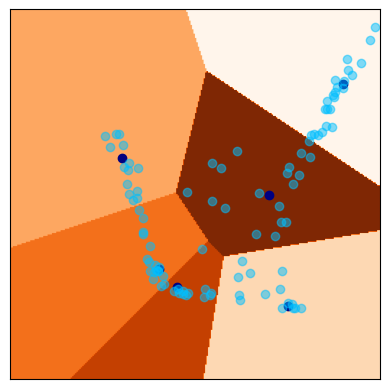

[101/200] 	Loss_D: -0.0096	Loss_G: 0.0077
[102/200] 	Loss_D: -0.0073	Loss_G: 0.0069
[103/200] 	Loss_D: -0.0070	Loss_G: 0.0092
[104/200] 	Loss_D: -0.0089	Loss_G: 0.0088
[105/200] 	Loss_D: -0.0085	Loss_G: 0.0048
[106/200] 	Loss_D: -0.0066	Loss_G: 0.0085
[107/200] 	Loss_D: -0.0111	Loss_G: 0.0027
[108/200] 	Loss_D: -0.0111	Loss_G: 0.0036
[109/200] 	Loss_D: -0.0081	Loss_G: 0.0103
[110/200] 	Loss_D: -0.0064	Loss_G: 0.0042
[111/200] 	Loss_D: -0.0086	Loss_G: 0.0054
[112/200] 	Loss_D: -0.0103	Loss_G: 0.0119
[113/200] 	Loss_D: -0.0090	Loss_G: 0.0076
[114/200] 	Loss_D: -0.0084	Loss_G: 0.0062
[115/200] 	Loss_D: -0.0059	Loss_G: 0.0090
[116/200] 	Loss_D: -0.0098	Loss_G: 0.0090
[117/200] 	Loss_D: -0.0089	Loss_G: 0.0077
[118/200] 	Loss_D: -0.0103	Loss_G: 0.0090
[119/200] 	Loss_D: -0.0087	Loss_G: 0.0082
[120/200] 	Loss_D: -0.0068	Loss_G: 0.0070


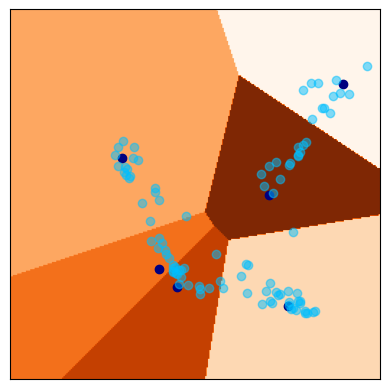

[121/200] 	Loss_D: -0.0050	Loss_G: 0.0100
[122/200] 	Loss_D: -0.0093	Loss_G: 0.0049
[123/200] 	Loss_D: -0.0084	Loss_G: 0.0060
[124/200] 	Loss_D: -0.0081	Loss_G: 0.0083
[125/200] 	Loss_D: -0.0080	Loss_G: 0.0066
[126/200] 	Loss_D: -0.0057	Loss_G: 0.0074
[127/200] 	Loss_D: -0.0079	Loss_G: 0.0068
[128/200] 	Loss_D: -0.0082	Loss_G: 0.0050
[129/200] 	Loss_D: -0.0083	Loss_G: 0.0075
[130/200] 	Loss_D: -0.0069	Loss_G: 0.0074
[131/200] 	Loss_D: -0.0068	Loss_G: 0.0068
[132/200] 	Loss_D: -0.0069	Loss_G: 0.0040
[133/200] 	Loss_D: -0.0073	Loss_G: 0.0071
[134/200] 	Loss_D: -0.0074	Loss_G: 0.0064
[135/200] 	Loss_D: -0.0078	Loss_G: 0.0066
[136/200] 	Loss_D: -0.0078	Loss_G: 0.0050
[137/200] 	Loss_D: -0.0070	Loss_G: 0.0075
[138/200] 	Loss_D: -0.0069	Loss_G: 0.0080
[139/200] 	Loss_D: -0.0083	Loss_G: 0.0056
[140/200] 	Loss_D: -0.0052	Loss_G: 0.0062


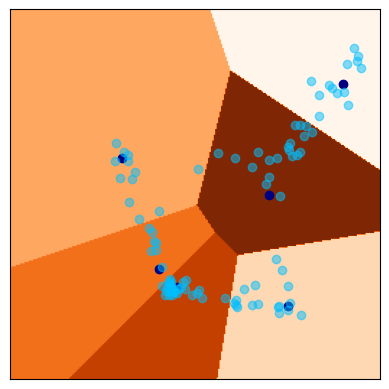

[141/200] 	Loss_D: -0.0084	Loss_G: 0.0048
[142/200] 	Loss_D: -0.0116	Loss_G: 0.0080
[143/200] 	Loss_D: -0.0087	Loss_G: 0.0021
[144/200] 	Loss_D: -0.0065	Loss_G: 0.0068
[145/200] 	Loss_D: -0.0085	Loss_G: 0.0059
[146/200] 	Loss_D: -0.0069	Loss_G: 0.0053
[147/200] 	Loss_D: -0.0093	Loss_G: 0.0085
[148/200] 	Loss_D: -0.0088	Loss_G: 0.0071
[149/200] 	Loss_D: -0.0107	Loss_G: 0.0015
[150/200] 	Loss_D: -0.0070	Loss_G: 0.0068
[151/200] 	Loss_D: -0.0078	Loss_G: 0.0059
[152/200] 	Loss_D: -0.0058	Loss_G: 0.0081
[153/200] 	Loss_D: -0.0061	Loss_G: 0.0059
[154/200] 	Loss_D: -0.0063	Loss_G: 0.0073
[155/200] 	Loss_D: -0.0041	Loss_G: 0.0092
[156/200] 	Loss_D: -0.0068	Loss_G: 0.0076
[157/200] 	Loss_D: -0.0086	Loss_G: 0.0061
[158/200] 	Loss_D: -0.0061	Loss_G: 0.0063
[159/200] 	Loss_D: -0.0048	Loss_G: 0.0085
[160/200] 	Loss_D: -0.0075	Loss_G: 0.0062


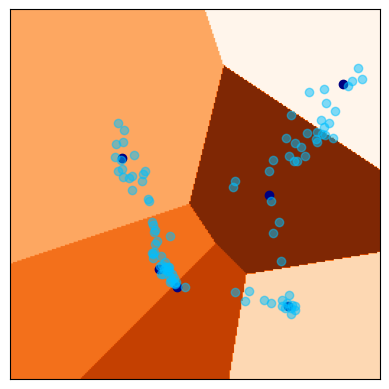

[161/200] 	Loss_D: -0.0068	Loss_G: 0.0114
[162/200] 	Loss_D: -0.0062	Loss_G: 0.0063
[163/200] 	Loss_D: -0.0100	Loss_G: 0.0028
[164/200] 	Loss_D: -0.0062	Loss_G: 0.0076
[165/200] 	Loss_D: -0.0091	Loss_G: 0.0087
[166/200] 	Loss_D: -0.0080	Loss_G: 0.0061
[167/200] 	Loss_D: -0.0060	Loss_G: 0.0059
[168/200] 	Loss_D: -0.0061	Loss_G: 0.0070
[169/200] 	Loss_D: -0.0087	Loss_G: 0.0040
[170/200] 	Loss_D: -0.0065	Loss_G: 0.0072
[171/200] 	Loss_D: -0.0060	Loss_G: 0.0049
[172/200] 	Loss_D: -0.0055	Loss_G: 0.0054
[173/200] 	Loss_D: -0.0065	Loss_G: 0.0048
[174/200] 	Loss_D: -0.0064	Loss_G: 0.0073
[175/200] 	Loss_D: -0.0102	Loss_G: 0.0013
[176/200] 	Loss_D: -0.0131	Loss_G: 0.0091
[177/200] 	Loss_D: -0.0048	Loss_G: 0.0034
[178/200] 	Loss_D: -0.0060	Loss_G: 0.0064
[179/200] 	Loss_D: -0.0074	Loss_G: 0.0062
[180/200] 	Loss_D: -0.0088	Loss_G: 0.0045


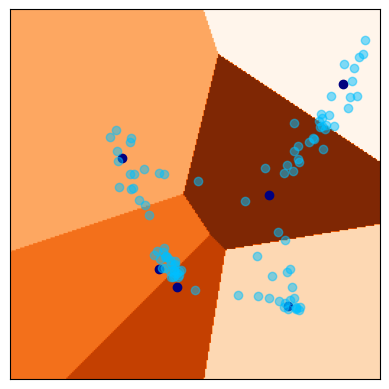

[181/200] 	Loss_D: -0.0073	Loss_G: 0.0053
[182/200] 	Loss_D: -0.0065	Loss_G: 0.0078
[183/200] 	Loss_D: -0.0065	Loss_G: 0.0056
[184/200] 	Loss_D: -0.0060	Loss_G: 0.0060
[185/200] 	Loss_D: -0.0066	Loss_G: 0.0064
[186/200] 	Loss_D: -0.0077	Loss_G: 0.0072
[187/200] 	Loss_D: -0.0070	Loss_G: 0.0053
[188/200] 	Loss_D: -0.0064	Loss_G: 0.0062
[189/200] 	Loss_D: -0.0115	Loss_G: 0.0094
[190/200] 	Loss_D: -0.0053	Loss_G: 0.0070
[191/200] 	Loss_D: -0.0073	Loss_G: 0.0058
[192/200] 	Loss_D: -0.0066	Loss_G: 0.0074
[193/200] 	Loss_D: -0.0060	Loss_G: 0.0048
[194/200] 	Loss_D: -0.0084	Loss_G: 0.0060
[195/200] 	Loss_D: -0.0090	Loss_G: 0.0078
[196/200] 	Loss_D: -0.0072	Loss_G: 0.0054
[197/200] 	Loss_D: -0.0062	Loss_G: 0.0067
[198/200] 	Loss_D: -0.0062	Loss_G: 0.0075
[199/200] 	Loss_D: -0.0065	Loss_G: 0.0071


<All keys matched successfully>

In [24]:
lrgen = 0.002   # learning rate for generator

## parameters for training
n_epochs = 200
niterD=200
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lrgen)

v = torch.zeros(n, device=device, requires_grad=True)
optimD = optim.Adam([v], lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 20

# Main loop
for epoch in range(1,n_epochs):

        ############################
        ### Train discriminator (niterD iterations)
        ############################
        Gloss = torch.tensor(0.0, device=device)
        Dloss = torch.tensor(0.0, device=device)
        for iter in range(0,niterD):
            z = torch.randn(b, n_in, device=device)
            x = G(z)
            optimD.zero_grad()
            Dloss = lossdisc(x,y,v,nu)
            Dloss.backward()
            optimD.step()


        ############################
        ### Train generator (niterG iterations)
        ############################
        for iter in range(0,niterG):
            z = torch.randn(b, n_in, device=device)
            x = G(z)
            optimG.zero_grad()
            Gloss = -lossdisc(x,y,v,nu)
            Gloss.backward()
            optimG.step()

        # Output training stats
        print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
        Glosses.append(Gloss.item())
        Dlosses.append(-Dloss.item())


        if(epoch % iter_display == 0):
            Tx,cx = transport_and_color(xgrid,y,v.detach())
            fig = plt.figure(dpi=100)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(cx.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
            plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
            z = torch.randn(b, 1, n_in, device=device)
            x = G(z)
            xd = x.detach().squeeze(1)
            plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
            plt.show()

# Save final generator for later use
wgansd = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgansd.load_state_dict(G.state_dict())

In [25]:
wgansd = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgansd.load_state_dict(G.state_dict())

<All keys matched successfully>

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

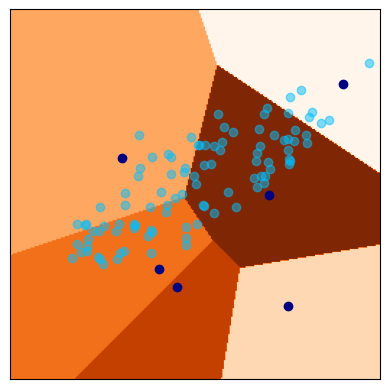

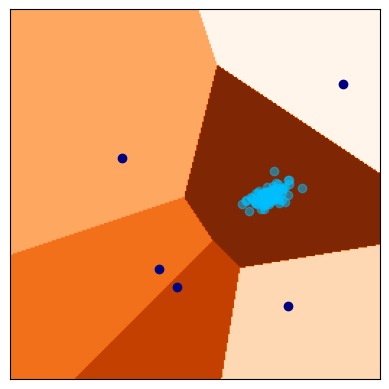

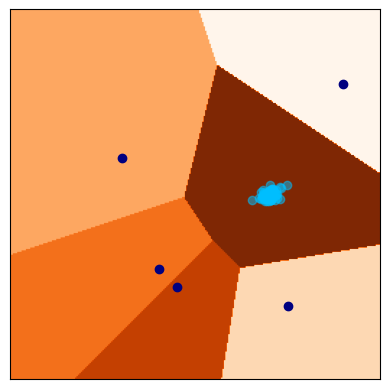

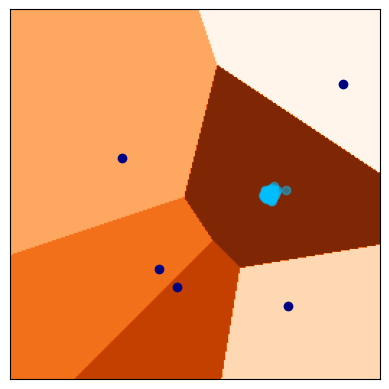

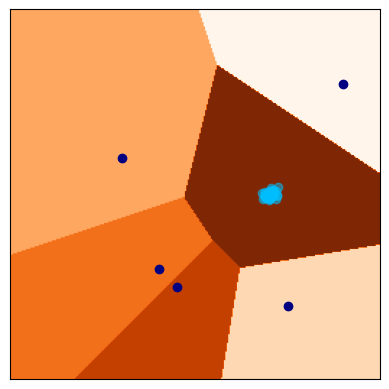

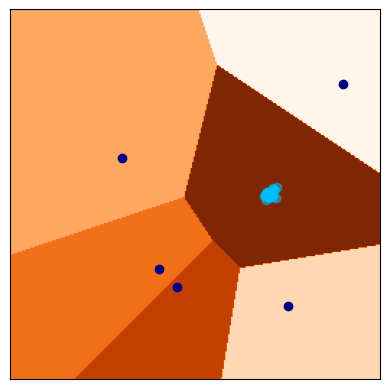

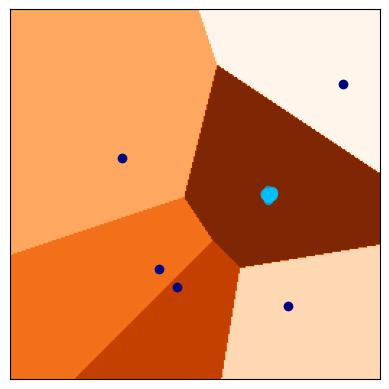

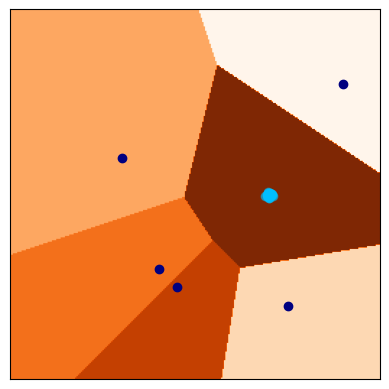

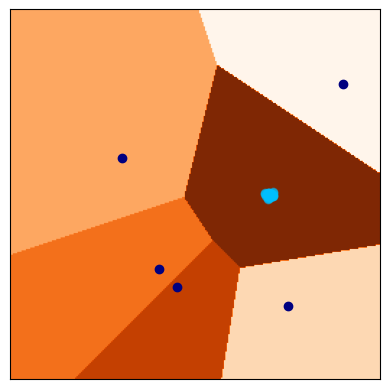

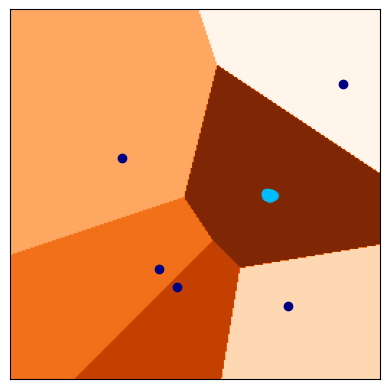

In [26]:
## Traina new generator with the same discriminator

lrgen = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for discriminator
## parameters for training
n_iter_G = 1000
iter_display = 100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator only
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# Optimizer for generator
optimG = optim.Adam(G.parameters(), lr=lrgen, betas=(beta_1, beta_2))

Glosses = []

# Main loop
for iter in range(n_iter_G):

    ############################
    ### Train generator (niterG iterations)
    ############################
    Gloss = torch.tensor(0.0, device=device)
    z = torch.randn(b, n_in, device=device)
    x = G(z)
    optimG.zero_grad()
    Gloss = -lossdisc(x,y,v,nu)
    Gloss.backward()
    optimG.step()

    # Output training stats
    Glosses.append(Gloss.item())

    if(iter % iter_display == 0):
        Tx,cx = transport_and_color(xgrid,y,v.detach())
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cx.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.show()

<br/><br/><br/><br/>

# Exercise 4: The Impact of Parameters

The goal of this final exercise is to study the impact of parameters in the GAN/WGAN learning strategy. You may copy parts of code written, and adapt some parts to answer the following questions.

QUESTION: Examine the impact of the min-max optimization strategy (learning rate, ADAM $\beta$ parameters) in the learning process of the generative model.

### Impact of learning rates

In [27]:
# # run this cell to see the impact of learning rates

# for lrgen in [0.0005, 0.002, 0.005, 0.01]:
#   for lrdisc in [0.0005, 0.002, 0.005, 0.01]:

#     print(f'lrgen = {lrgen}, lrdisc = {lrdisc}')

#     ## parameters for training
#     n_epochs = 100
#     niterD=100
#     niterG=10

#     torch.manual_seed(1)  # initialize random seed for reproducibility

#     # Initialize generators and discriminators
#     G = Generator(n_in=n_in, n_out=d, n_hid=20, nlayers=3, device=device)
#     D = Discriminator(n_in=d, n_hid=10).to(device)

#     # Optimizer for generator
#     optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))
#     optimG = optim.Adam(G.parameters(), lr=lrgen, betas=(beta_1, beta_2))

#     Glosses = []
#     Dlosses = []

#     iter_display = 10

#     # Main loop
#     for epoch in range(n_epochs):

#         ############################
#         ### Train discriminator (niterD iterations)
#         ############################
#         Gloss = torch.tensor(0.0, device=device)
#         Dloss = torch.tensor(0.0, device=device)
#         for iter in range(0,niterD):
#             z = torch.randn(b, n_in, device=device)
#             x = G(z)
#             optimD.zero_grad()
#             Dloss = -torch.mean(torch.log(1-D(x))) - torch.mean(torch.log(D(y)))
#             Dloss.backward()
#             optimD.step()

#         ############################
#         ### Train generator (niterG iterations)
#         ############################
#         for iter in range(0,niterG):
#             z = torch.randn(b, n_in, device=device)
#             x = G(z)
#             optimG.zero_grad()
#             Gloss = torch.mean(torch.log(1-D(x)))
#             Gloss.backward()
#             optimG.step()

#         # Output training stats
#         # print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
#         #   % (epoch, n_epochs, Dloss.item(), Gloss.item()))
#         Glosses.append(Gloss.item())
#         Dlosses.append(-Dloss.item())


#         if(epoch % iter_display == 0):
#             Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
#             z = torch.randn(b, 1, n_in, device=device)
#             x = G(z)
#             xd = x.detach().squeeze(1)
#             strtitle = 'Epoch '+str(epoch)
#             fig = plt.figure(dpi=100)
#             plt.xticks([])
#             plt.yticks([])
#             plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
#             plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
#             plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
#             plt.title(strtitle)
#             plt.show()

#     ## Plot the losses
#     plt.figure(dpi=100)
#     plt.plot(Dlosses,label='D')
#     plt.plot(Glosses,label='G')
#     plt.title('Loss evolution')
#     plt.legend()
#     plt.show()

### Impact of $\beta$

In [28]:
# # run this cell to see the impact of beta

# for beta_1g in [0.4, 0.5, 0.6]:
#   for beta_1d in [0.4, 0.5, 0.6]:
#     for beta_2g in [0.9, 0.999, 0.9999]:
#       for beta_2d in [0.9, 0.999, 0.9999]:

#         print(f'beta_1g = {beta_1g}, beta_1d = {beta_1d}')
#         print(f'beta_2g = {beta_2g}, beta_2d = {beta_2d}')

#         ## parameters for training
#         n_epochs = 100
#         niterD=100
#         niterG=10

#         lrgen = 0.002
#         lrdisc = 0.002

#         torch.manual_seed(1)  # initialize random seed for reproducibility

#         # Initialize generators and discriminators
#         G = Generator(n_in=n_in, n_out=d, n_hid=20, nlayers=3, device=device)
#         D = Discriminator(n_in=d, n_hid=10).to(device)

#         # Optimizer for generator
#         optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1d, beta_2d))
#         optimG = optim.Adam(G.parameters(), lr=lrgen, betas=(beta_1g, beta_2g))

#         Glosses = []
#         Dlosses = []

#         iter_display = 10

#         # Main loop
#         for epoch in range(n_epochs):

#             ############################
#             ### Train discriminator (niterD iterations)
#             ############################
#             Gloss = torch.tensor(0.0, device=device)
#             Dloss = torch.tensor(0.0, device=device)
#             for iter in range(0,niterD):
#                 z = torch.randn(b, n_in, device=device)
#                 x = G(z)
#                 optimD.zero_grad()
#                 Dloss = -torch.mean(torch.log(1-D(x))) - torch.mean(torch.log(D(y)))
#                 Dloss.backward()
#                 optimD.step()

#             ############################
#             ### Train generator (niterG iterations)
#             ############################
#             for iter in range(0,niterG):
#                 z = torch.randn(b, n_in, device=device)
#                 x = G(z)
#                 optimG.zero_grad()
#                 Gloss = torch.mean(torch.log(1-D(x)))
#                 Gloss.backward()
#                 optimG.step()

#             # Output training stats
#             # print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
#             #   % (epoch, n_epochs, Dloss.item(), Gloss.item()))
#             Glosses.append(Gloss.item())
#             Dlosses.append(-Dloss.item())


#             if(epoch % iter_display == 0):
#                 Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
#                 z = torch.randn(b, 1, n_in, device=device)
#                 x = G(z)
#                 xd = x.detach().squeeze(1)
#                 strtitle = 'Epoch '+str(epoch)
#                 fig = plt.figure(dpi=100)
#                 plt.xticks([])
#                 plt.yticks([])
#                 plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
#                 plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
#                 plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
#                 plt.title(strtitle)
#                 plt.show()

#         ## Plot the losses
#         plt.figure(dpi=100)
#         plt.plot(Dlosses,label='D')
#         plt.plot(Glosses,label='G')
#         plt.title('Loss evolution')
#         plt.legend()
#         plt.show()

QUESTION: Examine the impact of the min-max optimization strategy (number of updates of $D$ or $G$ per epoch)  in the learning process of the generative model.

In [29]:
# # run this cell to see the impact of the min-max optimization strategy

# for niterD in [10, 100, 1000]:
#   for niterG in [1, 10, 100]:

#     print(f'niterD = {niterD}, niterG = {niterG}')

#     ## parameters for training
#     n_epochs = 100

#     beta_1 = 0.5
#     beta_2 = 0.999

#     lrgen = 0.002
#     lrdisc = 0.002

#     torch.manual_seed(1)  # initialize random seed for reproducibility

#     # Initialize generators and discriminators
#     G = Generator(n_in=n_in, n_out=d, n_hid=20, nlayers=3, device=device)
#     D = Discriminator(n_in=d, n_hid=10).to(device)

#     # Optimizer for generator
#     optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))
#     optimG = optim.Adam(G.parameters(), lr=lrgen, betas=(beta_1, beta_2))

#     Glosses = []
#     Dlosses = []

#     iter_display = 10

#     # Main loop
#     for epoch in range(n_epochs):

#         ############################
#         ### Train discriminator (niterD iterations)
#         ############################
#         Gloss = torch.tensor(0.0, device=device)
#         Dloss = torch.tensor(0.0, device=device)
#         for iter in range(0,niterD):
#             z = torch.randn(b, n_in, device=device)
#             x = G(z)
#             optimD.zero_grad()
#             Dloss = -torch.mean(torch.log(1-D(x))) - torch.mean(torch.log(D(y)))
#             Dloss.backward()
#             optimD.step()

#         ############################
#         ### Train generator (niterG iterations)
#         ############################
#         for iter in range(0,niterG):
#             z = torch.randn(b, n_in, device=device)
#             x = G(z)
#             optimG.zero_grad()
#             Gloss = torch.mean(torch.log(1-D(x)))
#             Gloss.backward()
#             optimG.step()

#         # Output training stats
#         # print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
#         #   % (epoch, n_epochs, Dloss.item(), Gloss.item()))
#         Glosses.append(Gloss.item())
#         Dlosses.append(-Dloss.item())


#         if(epoch % iter_display == 0):
#             Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
#             z = torch.randn(b, 1, n_in, device=device)
#             x = G(z)
#             xd = x.detach().squeeze(1)
#             strtitle = 'Epoch '+str(epoch)
#             fig = plt.figure(dpi=100)
#             plt.xticks([])
#             plt.yticks([])
#             plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
#             plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
#             plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
#             plt.title(strtitle)
#             plt.show()
#     ## Plot the losses
#     plt.figure(dpi=100)
#     plt.plot(Dlosses,label='D')
#     plt.plot(Glosses,label='G')
#     plt.title('Loss evolution')
#     plt.legend()
#     plt.show()

We see that the training can be pretty unstable. It is essential to select hyperparameters (optimization parameters and min-max optimization strategy) carefully to obtain meaningful training.

QUESTION:

The semi-discrete formulation of WGAN allows to use general cost functions.

Try and compare semi-discrete learning with $p=1$ or $p=2$ (or even other values).

[1/200] 	Loss_D: -0.2412	Loss_G: 0.1962
[2/200] 	Loss_D: -0.2180	Loss_G: 0.1948
[3/200] 	Loss_D: -0.1964	Loss_G: 0.1787
[4/200] 	Loss_D: -0.1861	Loss_G: 0.1733
[5/200] 	Loss_D: -0.1854	Loss_G: 0.1636
[6/200] 	Loss_D: -0.1802	Loss_G: 0.1614
[7/200] 	Loss_D: -0.1634	Loss_G: 0.1717
[8/200] 	Loss_D: -0.1721	Loss_G: 0.1580
[9/200] 	Loss_D: -0.1590	Loss_G: 0.1688
[10/200] 	Loss_D: -0.1535	Loss_G: 0.1618
[11/200] 	Loss_D: -0.1428	Loss_G: 0.1412
[12/200] 	Loss_D: -0.1665	Loss_G: 0.1605
[13/200] 	Loss_D: -0.1389	Loss_G: 0.1409
[14/200] 	Loss_D: -0.1536	Loss_G: 0.1530
[15/200] 	Loss_D: -0.1400	Loss_G: 0.1248
[16/200] 	Loss_D: -0.1363	Loss_G: 0.1372
[17/200] 	Loss_D: -0.1259	Loss_G: 0.1304
[18/200] 	Loss_D: -0.1325	Loss_G: 0.1321
[19/200] 	Loss_D: -0.1415	Loss_G: 0.1174
[20/200] 	Loss_D: -0.1258	Loss_G: 0.1244


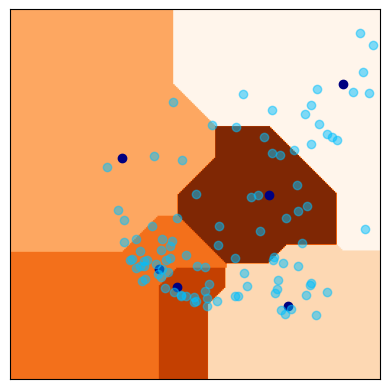

[21/200] 	Loss_D: -0.1410	Loss_G: 0.1180
[22/200] 	Loss_D: -0.1367	Loss_G: 0.1284
[23/200] 	Loss_D: -0.1246	Loss_G: 0.1325
[24/200] 	Loss_D: -0.1289	Loss_G: 0.1165
[25/200] 	Loss_D: -0.1392	Loss_G: 0.1441
[26/200] 	Loss_D: -0.1149	Loss_G: 0.1214
[27/200] 	Loss_D: -0.1204	Loss_G: 0.1173
[28/200] 	Loss_D: -0.1172	Loss_G: 0.1269
[29/200] 	Loss_D: -0.1255	Loss_G: 0.1224
[30/200] 	Loss_D: -0.1358	Loss_G: 0.1192
[31/200] 	Loss_D: -0.1334	Loss_G: 0.1181
[32/200] 	Loss_D: -0.1157	Loss_G: 0.1167
[33/200] 	Loss_D: -0.1347	Loss_G: 0.1174
[34/200] 	Loss_D: -0.1133	Loss_G: 0.1186
[35/200] 	Loss_D: -0.1160	Loss_G: 0.1305
[36/200] 	Loss_D: -0.1228	Loss_G: 0.1134
[37/200] 	Loss_D: -0.1135	Loss_G: 0.1142
[38/200] 	Loss_D: -0.1133	Loss_G: 0.1132
[39/200] 	Loss_D: -0.1151	Loss_G: 0.1188
[40/200] 	Loss_D: -0.1127	Loss_G: 0.1154


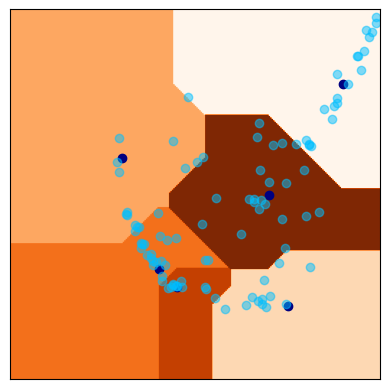

[41/200] 	Loss_D: -0.1149	Loss_G: 0.1187
[42/200] 	Loss_D: -0.1202	Loss_G: 0.1151
[43/200] 	Loss_D: -0.1190	Loss_G: 0.1053
[44/200] 	Loss_D: -0.1277	Loss_G: 0.1030
[45/200] 	Loss_D: -0.1168	Loss_G: 0.1129
[46/200] 	Loss_D: -0.1036	Loss_G: 0.1113
[47/200] 	Loss_D: -0.1181	Loss_G: 0.1193
[48/200] 	Loss_D: -0.1084	Loss_G: 0.1188
[49/200] 	Loss_D: -0.1164	Loss_G: 0.0881
[50/200] 	Loss_D: -0.1104	Loss_G: 0.1139
[51/200] 	Loss_D: -0.1089	Loss_G: 0.0968
[52/200] 	Loss_D: -0.0900	Loss_G: 0.1183
[53/200] 	Loss_D: -0.1193	Loss_G: 0.0993
[54/200] 	Loss_D: -0.1100	Loss_G: 0.1201
[55/200] 	Loss_D: -0.1197	Loss_G: 0.1037
[56/200] 	Loss_D: -0.1044	Loss_G: 0.0972
[57/200] 	Loss_D: -0.1105	Loss_G: 0.1195
[58/200] 	Loss_D: -0.1115	Loss_G: 0.0716
[59/200] 	Loss_D: -0.1076	Loss_G: 0.1023
[60/200] 	Loss_D: -0.1063	Loss_G: 0.0873


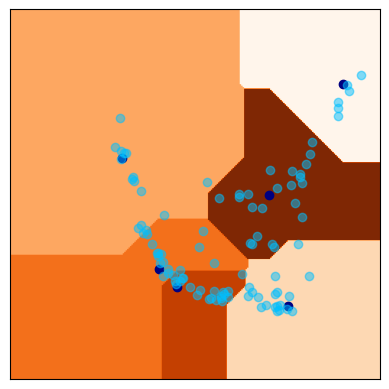

[61/200] 	Loss_D: -0.1091	Loss_G: 0.1129
[62/200] 	Loss_D: -0.1063	Loss_G: 0.1081
[63/200] 	Loss_D: -0.1046	Loss_G: 0.1046
[64/200] 	Loss_D: -0.1059	Loss_G: 0.1100
[65/200] 	Loss_D: -0.1094	Loss_G: 0.1005
[66/200] 	Loss_D: -0.1076	Loss_G: 0.1020
[67/200] 	Loss_D: -0.1090	Loss_G: 0.1030
[68/200] 	Loss_D: -0.1035	Loss_G: 0.0984
[69/200] 	Loss_D: -0.1050	Loss_G: 0.0920
[70/200] 	Loss_D: -0.1009	Loss_G: 0.1046
[71/200] 	Loss_D: -0.1117	Loss_G: 0.1065
[72/200] 	Loss_D: -0.1067	Loss_G: 0.0996
[73/200] 	Loss_D: -0.0942	Loss_G: 0.0955
[74/200] 	Loss_D: -0.1038	Loss_G: 0.0970
[75/200] 	Loss_D: -0.1050	Loss_G: 0.0905
[76/200] 	Loss_D: -0.0854	Loss_G: 0.0958
[77/200] 	Loss_D: -0.0952	Loss_G: 0.1022
[78/200] 	Loss_D: -0.0912	Loss_G: 0.1045
[79/200] 	Loss_D: -0.1009	Loss_G: 0.0932
[80/200] 	Loss_D: -0.0797	Loss_G: 0.0830


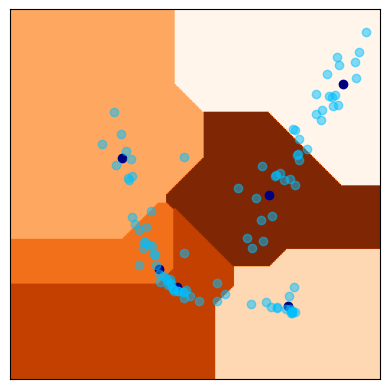

[81/200] 	Loss_D: -0.0961	Loss_G: 0.0869
[82/200] 	Loss_D: -0.0879	Loss_G: 0.0871
[83/200] 	Loss_D: -0.0943	Loss_G: 0.0950
[84/200] 	Loss_D: -0.1001	Loss_G: 0.0928
[85/200] 	Loss_D: -0.0928	Loss_G: 0.0861
[86/200] 	Loss_D: -0.0809	Loss_G: 0.0857
[87/200] 	Loss_D: -0.0973	Loss_G: 0.0893
[88/200] 	Loss_D: -0.0980	Loss_G: 0.0921
[89/200] 	Loss_D: -0.0940	Loss_G: 0.0872
[90/200] 	Loss_D: -0.0941	Loss_G: 0.0847
[91/200] 	Loss_D: -0.0995	Loss_G: 0.0554
[92/200] 	Loss_D: -0.0897	Loss_G: 0.0819
[93/200] 	Loss_D: -0.0822	Loss_G: 0.0897
[94/200] 	Loss_D: -0.0898	Loss_G: 0.0835
[95/200] 	Loss_D: -0.0930	Loss_G: 0.0700
[96/200] 	Loss_D: -0.1051	Loss_G: 0.0855
[97/200] 	Loss_D: -0.0938	Loss_G: 0.0859
[98/200] 	Loss_D: -0.1011	Loss_G: 0.0787
[99/200] 	Loss_D: -0.0987	Loss_G: 0.0835
[100/200] 	Loss_D: -0.0886	Loss_G: 0.0773


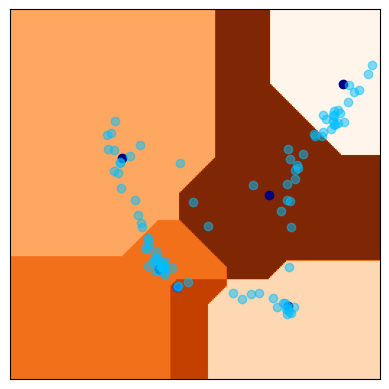

[101/200] 	Loss_D: -0.1008	Loss_G: 0.0851
[102/200] 	Loss_D: -0.0932	Loss_G: 0.0855
[103/200] 	Loss_D: -0.0781	Loss_G: 0.0809
[104/200] 	Loss_D: -0.0917	Loss_G: 0.0853
[105/200] 	Loss_D: -0.0865	Loss_G: 0.0900
[106/200] 	Loss_D: -0.0891	Loss_G: 0.0619
[107/200] 	Loss_D: -0.0948	Loss_G: 0.0716
[108/200] 	Loss_D: -0.0797	Loss_G: 0.0818
[109/200] 	Loss_D: -0.0894	Loss_G: 0.0761
[110/200] 	Loss_D: -0.0891	Loss_G: 0.0782
[111/200] 	Loss_D: -0.0822	Loss_G: 0.0818
[112/200] 	Loss_D: -0.0924	Loss_G: 0.0728
[113/200] 	Loss_D: -0.0904	Loss_G: 0.0853
[114/200] 	Loss_D: -0.0920	Loss_G: 0.0828
[115/200] 	Loss_D: -0.0739	Loss_G: 0.0734
[116/200] 	Loss_D: -0.0980	Loss_G: 0.0845
[117/200] 	Loss_D: -0.0774	Loss_G: 0.0836
[118/200] 	Loss_D: -0.0912	Loss_G: 0.0701
[119/200] 	Loss_D: -0.0817	Loss_G: 0.0808
[120/200] 	Loss_D: -0.0706	Loss_G: 0.0652


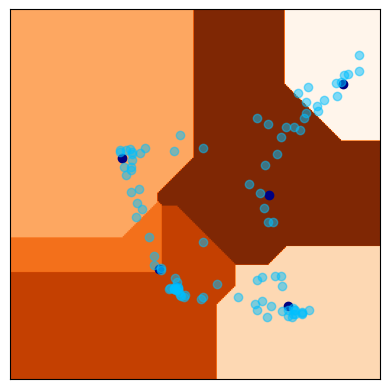

[121/200] 	Loss_D: -0.0931	Loss_G: 0.0972
[122/200] 	Loss_D: -0.0874	Loss_G: 0.0661
[123/200] 	Loss_D: -0.1022	Loss_G: 0.0685
[124/200] 	Loss_D: -0.0825	Loss_G: 0.0793
[125/200] 	Loss_D: -0.0774	Loss_G: 0.0713
[126/200] 	Loss_D: -0.0847	Loss_G: 0.0848
[127/200] 	Loss_D: -0.0785	Loss_G: 0.0771
[128/200] 	Loss_D: -0.0826	Loss_G: 0.0686
[129/200] 	Loss_D: -0.0815	Loss_G: 0.0811
[130/200] 	Loss_D: -0.0926	Loss_G: 0.0703
[131/200] 	Loss_D: -0.0880	Loss_G: 0.0821
[132/200] 	Loss_D: -0.0830	Loss_G: 0.0710
[133/200] 	Loss_D: -0.0851	Loss_G: 0.0882
[134/200] 	Loss_D: -0.0854	Loss_G: 0.0879
[135/200] 	Loss_D: -0.1014	Loss_G: 0.0675
[136/200] 	Loss_D: -0.0766	Loss_G: 0.0784
[137/200] 	Loss_D: -0.0831	Loss_G: 0.0563
[138/200] 	Loss_D: -0.0869	Loss_G: 0.0759
[139/200] 	Loss_D: -0.0886	Loss_G: 0.0673
[140/200] 	Loss_D: -0.0854	Loss_G: 0.0764


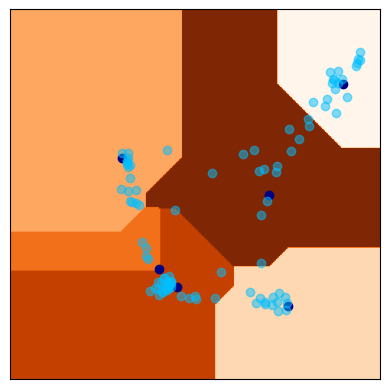

[141/200] 	Loss_D: -0.0851	Loss_G: 0.0830
[142/200] 	Loss_D: -0.0925	Loss_G: 0.0763
[143/200] 	Loss_D: -0.0764	Loss_G: 0.0799
[144/200] 	Loss_D: -0.0940	Loss_G: 0.0659
[145/200] 	Loss_D: -0.0814	Loss_G: 0.0876
[146/200] 	Loss_D: -0.0809	Loss_G: 0.0696
[147/200] 	Loss_D: -0.0787	Loss_G: 0.0773
[148/200] 	Loss_D: -0.0710	Loss_G: 0.0761
[149/200] 	Loss_D: -0.0925	Loss_G: 0.0585
[150/200] 	Loss_D: -0.0913	Loss_G: 0.0817
[151/200] 	Loss_D: -0.0963	Loss_G: 0.0648
[152/200] 	Loss_D: -0.0889	Loss_G: 0.0812
[153/200] 	Loss_D: -0.0847	Loss_G: 0.0732
[154/200] 	Loss_D: -0.0791	Loss_G: 0.0792
[155/200] 	Loss_D: -0.0765	Loss_G: 0.0744
[156/200] 	Loss_D: -0.0703	Loss_G: 0.0639
[157/200] 	Loss_D: -0.0811	Loss_G: 0.0826
[158/200] 	Loss_D: -0.0827	Loss_G: 0.0795
[159/200] 	Loss_D: -0.0800	Loss_G: 0.0700
[160/200] 	Loss_D: -0.0930	Loss_G: 0.0765


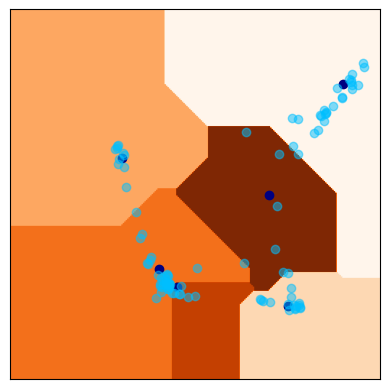

[161/200] 	Loss_D: -0.0859	Loss_G: 0.0684
[162/200] 	Loss_D: -0.0859	Loss_G: 0.0607
[163/200] 	Loss_D: -0.0713	Loss_G: 0.0789
[164/200] 	Loss_D: -0.0972	Loss_G: 0.0645
[165/200] 	Loss_D: -0.0826	Loss_G: 0.0738
[166/200] 	Loss_D: -0.0973	Loss_G: 0.0580
[167/200] 	Loss_D: -0.0825	Loss_G: 0.0724
[168/200] 	Loss_D: -0.0780	Loss_G: 0.0552
[169/200] 	Loss_D: -0.0932	Loss_G: 0.0726
[170/200] 	Loss_D: -0.0828	Loss_G: 0.0656
[171/200] 	Loss_D: -0.0827	Loss_G: 0.0735
[172/200] 	Loss_D: -0.0721	Loss_G: 0.0724
[173/200] 	Loss_D: -0.0798	Loss_G: 0.0644
[174/200] 	Loss_D: -0.0916	Loss_G: 0.0652
[175/200] 	Loss_D: -0.0823	Loss_G: 0.0742
[176/200] 	Loss_D: -0.0627	Loss_G: 0.0662
[177/200] 	Loss_D: -0.0799	Loss_G: 0.0536
[178/200] 	Loss_D: -0.0627	Loss_G: 0.0616
[179/200] 	Loss_D: -0.0654	Loss_G: 0.0664
[180/200] 	Loss_D: -0.0724	Loss_G: 0.0681


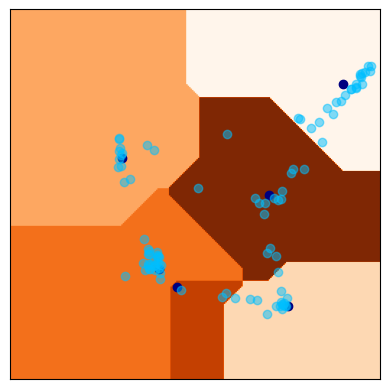

[181/200] 	Loss_D: -0.0791	Loss_G: 0.0507
[182/200] 	Loss_D: -0.0791	Loss_G: 0.0693
[183/200] 	Loss_D: -0.0857	Loss_G: 0.0666
[184/200] 	Loss_D: -0.0668	Loss_G: 0.0751
[185/200] 	Loss_D: -0.0753	Loss_G: 0.0666
[186/200] 	Loss_D: -0.0842	Loss_G: 0.0693
[187/200] 	Loss_D: -0.0771	Loss_G: 0.0563
[188/200] 	Loss_D: -0.0755	Loss_G: 0.0688
[189/200] 	Loss_D: -0.0819	Loss_G: 0.0633
[190/200] 	Loss_D: -0.0738	Loss_G: 0.0744
[191/200] 	Loss_D: -0.0762	Loss_G: 0.0507
[192/200] 	Loss_D: -0.0757	Loss_G: 0.0702
[193/200] 	Loss_D: -0.0659	Loss_G: 0.0565
[194/200] 	Loss_D: -0.0824	Loss_G: 0.0692
[195/200] 	Loss_D: -0.0700	Loss_G: 0.0594
[196/200] 	Loss_D: -0.0684	Loss_G: 0.0687
[197/200] 	Loss_D: -0.0661	Loss_G: 0.0713
[198/200] 	Loss_D: -0.0721	Loss_G: 0.0644
[199/200] 	Loss_D: -0.0639	Loss_G: 0.0732


In [30]:
## Reproduce joint training of semi-discrete WGAN for p=1

lrgen = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for discriminator
## parameters for training
n_epochs = 200
niterD=200
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

def lossdisc1(x,y,v,nu):
    return - ctransform(x,y,v,p=1).mean() - torch.sum(v*nu)

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lrgen)

v = torch.zeros(n, device=device, requires_grad=True)
optimD = optim.Adam([v], lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 20

# Main loop
for epoch in range(1,n_epochs):

        ############################
        ### Train discriminator (niterD iterations)
        ############################
        Gloss = torch.tensor(0.0, device=device)
        Dloss = torch.tensor(0.0, device=device)
        for iter in range(0,niterD):
            z = torch.randn(b, n_in, device=device)
            x = G(z)
            optimD.zero_grad()
            Dloss = lossdisc1(x,y,v,nu)
            Dloss.backward()
            optimD.step()


        ############################
        ### Train generator (niterG iterations)
        ############################
        for iter in range(0,niterG):
            z = torch.randn(b, n_in, device=device)
            x = G(z)
            optimG.zero_grad()
            Gloss = -lossdisc1(x,y,v,nu)
            Gloss.backward()
            optimG.step()

        # Output training stats
        print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
        Glosses.append(Gloss.item())
        Dlosses.append(-Dloss.item())


        if(epoch % iter_display == 0):
            Tx,cx = transport_and_color(xgrid,y,v.detach(),p=1)
            fig = plt.figure(dpi=100)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(cx.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
            plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
            z = torch.randn(b, 1, n_in, device=device)
            x = G(z)
            xd = x.detach().squeeze(1)
            plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
            plt.show()



With $p=1$, the semi-discrete formulation is more unstable.